In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import LinearSegmentedColormap
import xarray as xr
import cmocean.cm as cmo 
import gsw
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import PolyCollection
from scipy.spatial import Delaunay

from scipy.interpolate import griddata
from scipy.spatial import KDTree

from matplotlib.colors import ListedColormap
import matplotlib.patches as Patches
import matplotlib.gridspec as gridspec


from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import xarray as xr
import cmocean.cm as cmo 
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import matplotlib as mpl

## Data

In [4]:
path1 ='../../../automated_testing/integrated_tests/idealised/Thule/results_CLNC_250/'
path2 ='../../../automated_testing/integrated_tests/idealised/Thule/results_WLNC_250/'

In [24]:
# Seperat into variables
Va1 = Quad1['V']
V = Va1.T

Tria1 = Quad1['Tri'] - 1  
Tri = Tria1.T

triang = tri.Triangulation(V[:, 0], V[:, 1], Tri)

Hi = Quad1['Hi']
Hib = Quad1['Hib']
Hs = Quad1['Hs']
Hb= Quad1['Hb']
BMB = Quad1['BMB']
So = Quad1['S_ocean']
To = Quad1['T_ocean']
Tricc = Quad1['Tricc']

Va1last = Quad1last['V']
Vlast = Va1last.T

Tria1last = Quad1last['Tri'] - 1  
Trilast = Tria1last.T

trianglast = tri.Triangulation(Vlast[:, 0], Vlast[:, 1], Trilast)

Hilast = Quad1last['Hi']
Hiblast = Quad1last['Hib']
Hslast = Quad1last['Hs']
Hblast = Quad1last['Hb']
BMBlast = Quad1last['BMB']
Solast = Quad1last['S_ocean']
Tolast = Quad1last['T_ocean']
Tricclast = Quad1last['Tricc']

#Masks 

mask_gr = Quad1['mask_grounded_ice']
radius = 750000
distances1 = np.sqrt(V[:, 0]**2 + V[:, 1]**2)
mask_ocean = distances1 <= radius

Va1 = Lad1['V']
V1 = Va1.T

Tria1 = Lad1['Tri'] - 1  
Tri1 = Tria1.T

triang1 = tri.Triangulation(V1[:, 0], V1[:, 1], Tri1)

Hi_l1 = Lad1['Hi']
Hib_l1 = Lad1['Hib']
Hs_l1 = Lad1['Hs']
Hb_l1 = Lad1['Hb']
BMB_l1 = Lad1['BMB']
So1 = Lad1['S_ocean']
To1 = Lad1['T_ocean']
T_fp1 = Lad1['T_freezing_point']
mask_gr1 = Lad1['mask_grounded_ice']

Va2 = Lad2['V']
V2 = Va2.T

Tria2 = Lad2['Tri'] - 1  
Tri2 = Tria2.T

triang2 = tri.Triangulation(V2[:, 0], V2[:, 1], Tri2)

Hi_l2 = Lad2['Hi']
Hib_l2 = Lad2['Hib']
Hs_l2 = Lad2['Hs']
Hb_l2 = Lad2['Hb']
BMB_l2 = Lad2['BMB']
So2 = Lad2['S_ocean']
To2 = Lad2['T_ocean']
T_fp2 = Lad2['T_freezing_point']
mask_gr2 = Lad2['mask_grounded_ice']

Va3 = Lad3['V']
V3 = Va3.T

Tria3 = Lad3['Tri'] - 1  
Tri3 = Tria3.T

triang3 = tri.Triangulation(V3[:, 0], V3[:, 1], Tri3)

Hi_l3 = Lad3['Hi']
Hib_l3 = Lad3['Hib']
Hs_l3 = Lad3['Hs']
Hb_l3 = Lad3['Hb']
BMB_l3 = Lad3['BMB']
So3 = Lad3['S_ocean']
To3 = Lad3['T_ocean']
T_fp3 = Lad3['T_freezing_point']
mask_gr3 = Lad3['mask_grounded_ice']

In [14]:
n = 800000
m = n + 100000

In [13]:
u = 0
tfs = 20 
afs = 18 
tifs = 15 
cbfs = 18
ctfs = 15

In [17]:
def calculate_area_percentages(V, Hi, ranges):
    """
    Calculate percentage of area for each thickness range.
    
    Args:
        V: Array of vertices (N, 2)
        Hi: Array of thickness values (N,)
        ranges: List of tuples defining ranges [(min1, max1), (min2, max2), ...]
    
    Returns:
        List of area percentages for all ranges
    """
    # Convert inputs and remove NaN values
    vertices = np.asarray(V)
    thickness = np.asarray(Hi)
    valid_mask = ~np.isnan(thickness)
    vertices = vertices[valid_mask]
    thickness = thickness[valid_mask]
    
    # Return zeros if we don't have enough points for triangulation
    if len(vertices) < 3:
        return [0.0] * len(ranges)
    
    try:
        tri = Delaunay(vertices)
    except:
        # Return zeros if triangulation fails
        return [0.0] * len(ranges)
    
    # Get triangles and their properties
    triangles = tri.points[tri.simplices]
    tri_values = thickness[tri.simplices]
    tri_means = np.mean(tri_values, axis=1)
    
    # Calculate triangle areas
    a = triangles[:, 1] - triangles[:, 0]
    b = triangles[:, 2] - triangles[:, 0]
    areas = 0.5 * np.abs(a[:,0]*b[:,1] - a[:,1]*b[:,0])
    total_area = np.sum(areas)
    
    if total_area == 0:
        return [0.0] * len(ranges)
    
    # Calculate area percentages for each range
    percentages = []
    for min_val, max_val in ranges:
        in_range = (tri_means >= min_val) & (tri_means < max_val)
        range_area = np.sum(areas[in_range])
        percentages.append((range_area / total_area) * 100)
    
    return percentages

In [18]:
ranges = [100,200,300,400]
perc = calculate_area_percentages(V,Hi[0],ranges)

In [19]:

def area_weighted_average(vertices, nodal_values):
    """
    Compute area-weighted average for scattered data using Delaunay triangulation
    
    Parameters:
    vertices : array (N,2) - x,y coordinates of points
    nodal_values : array (N,) - values at each vertex
    
    Returns:
    weighted_avg : float - area-weighted mean
    """
    # Convert to numpy arrays if they're xarray DataArrays
    vertices = np.asarray(vertices)
    nodal_values = np.asarray(nodal_values)
    
    # Remove NaN values (both coordinates and corresponding values)
    valid_mask = ~np.isnan(nodal_values)
    vertices = vertices[valid_mask]
    nodal_values = nodal_values[valid_mask]
    
    # Create Delaunay triangulation
    try:
        tri = Delaunay(vertices)
    except:
        raise ValueError("Delaunay triangulation failed - check for duplicate points or colinearities")
    
    # Get vertex indices for all triangles
    triangles = tri.points[tri.simplices]  # Shape: (M,3,2)
    
    # Vectorized area calculation
    a = triangles[:, 1] - triangles[:, 0]
    b = triangles[:, 2] - triangles[:, 0]
    areas = 0.5 * np.abs(a[:,0]*b[:,1] - a[:,1]*b[:,0])
    
    # Mean value per triangle
    tri_values = nodal_values[tri.simplices]
    tri_means = np.mean(tri_values, axis=1)
    
    # Weighted average
    total_area = np.sum(areas)
    if total_area == 0:
        return np.nan
    
    return np.sum(areas * tri_means) / total_area

# Proper usage with your data:
V_array = np.asarray(V)  # Ensure V is a numpy array
Hi_values = Hi[0].where(mask0 & mask_ocean).values.flatten()

Hi_mean = area_weighted_average(V_array, Hi_values)
print(f"Area-weighted average ice thickness: {Hi_mean:.2f} m")

ValueError: Delaunay triangulation failed - check for duplicate points or colinearities

# Results

## Ice thickness and elevation

### Works

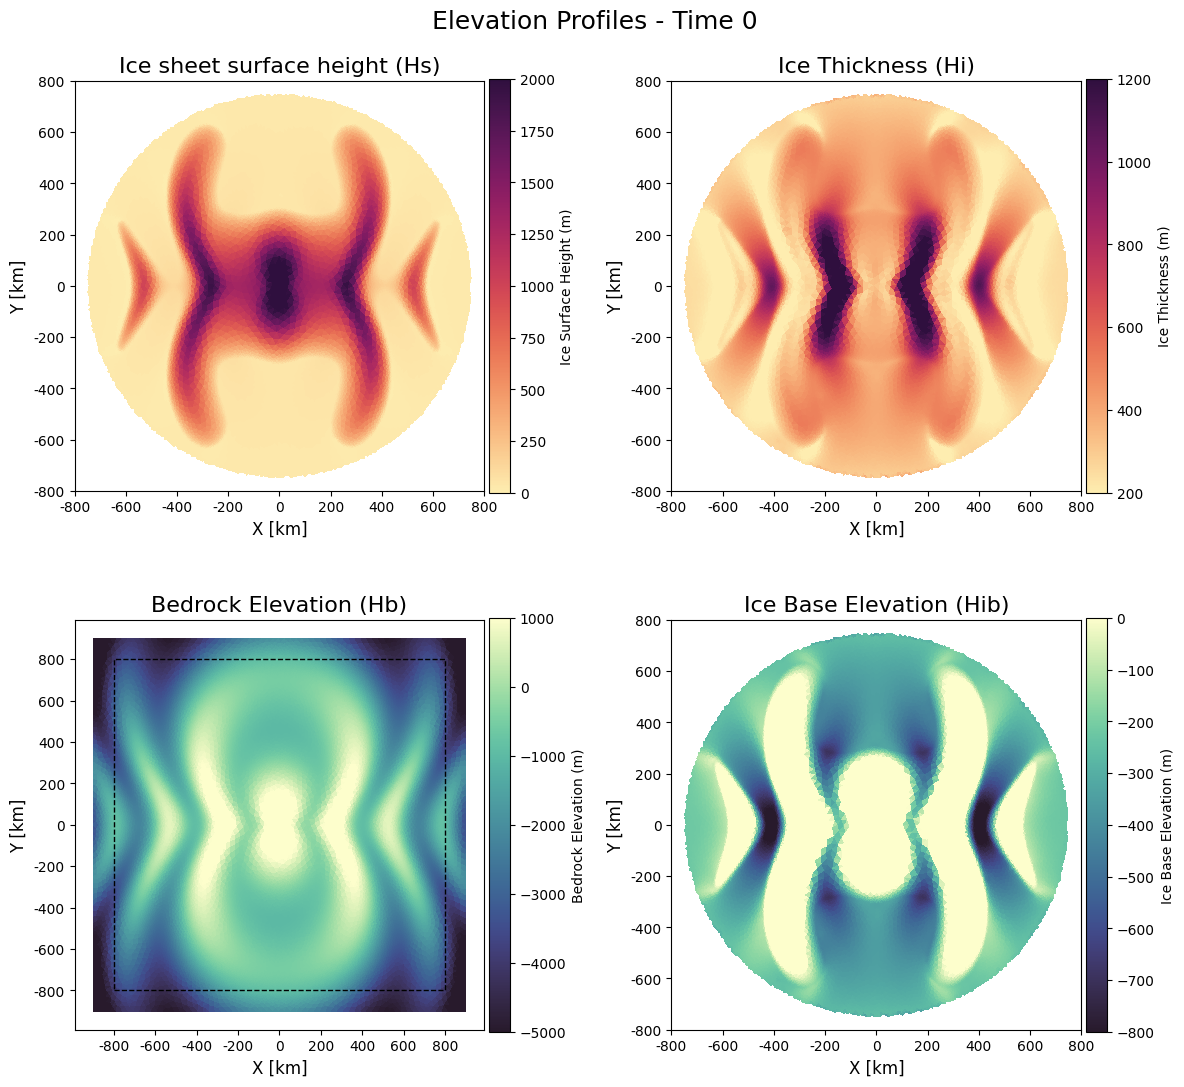

In [20]:
n = 800000

colorbar_kwargs = {
    'aspect': 20,
    'pad': 0.01,
    'shrink': 0.8, 
}

##############################################################################################################################

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle(f'Elevation Profiles - Time {u}', fontsize=18, x=0.5, y=0.92)


c0 = ax[0, 0].tripcolor(triang, Hs[u].where(mask_ocean), cmap=cmo.matter, vmin = 0 , vmax = 2000)
fig.colorbar(c0, ax=ax[0, 0], label="Ice Surface Height (m)", **colorbar_kwargs)
ax[0, 0].set_title('Ice sheet surface height (Hs)', fontsize=14)
#cont0 = ax[0, 0].tricontour(triang, Hs_l[u], levels=[0, 500, 1000, 1500], colors='k', linewidths=1)
#ax[0, 0].clabel(cont0, inline=True, fontsize=8)
ax[0, 0].set_xlim(-n,n)
ax[0, 0].set_ylim(-n,n)


c1 = ax[0, 1].tripcolor(triang, Hi[u].where(mask_ocean), cmap=cmo.matter, vmin = 200, vmax=1200)
fig.colorbar(c1, ax=ax[0, 1], label="Ice Thickness (m)", **colorbar_kwargs)
ax[0, 1].set_title('Ice Thickness (Hi)', fontsize=14)
#cont1 = ax[0, 1].tricontour(triang, Hi_l[u], levels=[0, 500, 1000, 1500], colors='k', linewidths=1)
#ax[0, 1].clabel(cont1, inline=True, fontsize=8)
ax[0, 1].set_xlim(-n,n)
ax[0, 1].set_ylim(-n,n)


c2 = ax[1, 0].tripcolor(triang, Hb[u], cmap=cmo.deep_r, vmin=-5000, vmax=1000)
fig.colorbar(c2, ax=ax[1, 0], label="Bedrock Elevation (m)", **colorbar_kwargs)
ax[1, 0].set_title('Bedrock Elevation (Hb)', fontsize=14)
#cont2 = ax[1, 0].tricontour(triang, Hb_l[u], levels=[-700, -500, -250, 0, 250], colors='k', linewidths=1)
#ax[1, 0].clabel(cont2, inline=True, fontsize=8)
box_x = [-800000, 800000, 800000, -800000, -800000]
box_y = [-800000, -800000, 800000, 800000, -800000]
ax[1, 0].plot(box_x, box_y, color='black', linestyle='--', linewidth=1)


c3 = ax[1, 1].tripcolor(triang, Hib[u].where(mask_ocean), cmap=cmo.deep_r , vmin = -800, vmax=0)
fig.colorbar(c3, ax=ax[1, 1], label="Ice Base Elevation (m)", **colorbar_kwargs)
ax[1, 1].set_title('Ice Base Elevation (Hib)', fontsize=14)
#cont3 = ax[1, 1].tricontour(triang, Hs_l[u] - Hi_l[u], levels=[-600, -300, 0, 300], colors='k', linewidths=1)
#ax[1, 1].clabel(cont3, inline=True, fontsize=8)
ax[1, 1].set_xlim(-n,n)
ax[1, 1].set_ylim(-n,n)
 

for i in range(2):
    for j in range(2):
        ax[i, j].set_aspect('equal')
        ax[i, j].title.set_fontsize(16)
        ax[i, j].set_xlabel('X [km]', fontsize=12)
        ax[i, j].set_ylabel('Y [km]', fontsize=12)
        ax[i, j].set_xticks(np.arange(-n, n + 1, 200000))
        ax[i, j].set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
        ax[i, j].set_yticks(np.arange(-n, n + 1, 200000))
        ax[i, j].set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [42]:
##COLD##
radius = 750000

CoQuad1 = xr.open_dataset(path1 + 'main_output_ANT_00001.nc')
CoQuad2 = xr.open_dataset(path1 + 'main_output_ANT_00002.nc')
CoQuad3 = xr.open_dataset(path1 + 'main_output_ANT_00003.nc')

Hi1 = CoQuad1['Hi']
BMB1 = CoQuad1['BMB']
Va1 = CoQuad1['V']
V1 = Va1.T
Tria1 = CoQuad1['Tri'] - 1  
Tri1 = Tria1.T
triang1 = tri.Triangulation(V1[:, 0], V1[:, 1], Tri1)

Hi2 = CoQuad2['Hi']
BMB2 = CoQuad2['BMB']
Va2 = CoQuad2['V']
V2 = Va2.T
Tria2 = CoQuad2['Tri'] - 1  
Tri2 = Tria2.T
triang2 = tri.Triangulation(V2[:, 0], V2[:, 1], Tri2)

Hi3 = CoQuad3['Hi']
BMB3 = CoQuad3['BMB']
Va3 = CoQuad3['V']
V3 = Va3.T
Tria3 = CoQuad3['Tri'] - 1  
Tri3 = Tria3.T
triang3 = tri.Triangulation(V3[:, 0], V3[:, 1], Tri3)

year = np.arange(0, 251, 50)

distances1 = np.sqrt(V1[:, 0]**2 + V1[:, 1]**2)
mask_ocean1 = distances1 <= radius

distances2 = np.sqrt(V2[:, 0]**2 + V2[:, 1]**2)
mask_ocean2 = distances2 <= radius

distances3 = np.sqrt(V3[:, 0]**2 + V3[:, 1]**2)
mask_ocean3 = distances3 <= radius

mask_gr1 = CoQuad1['mask_grounded_ice']
mask_gr2 = CoQuad2['mask_grounded_ice']
mask_gr3 = CoQuad3['mask_grounded_ice']

GL1 = CoQuad1['grounding_line']
GL2 = CoQuad2['grounding_line']
GL3 = CoQuad3['grounding_line']

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_18304/2384256142.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


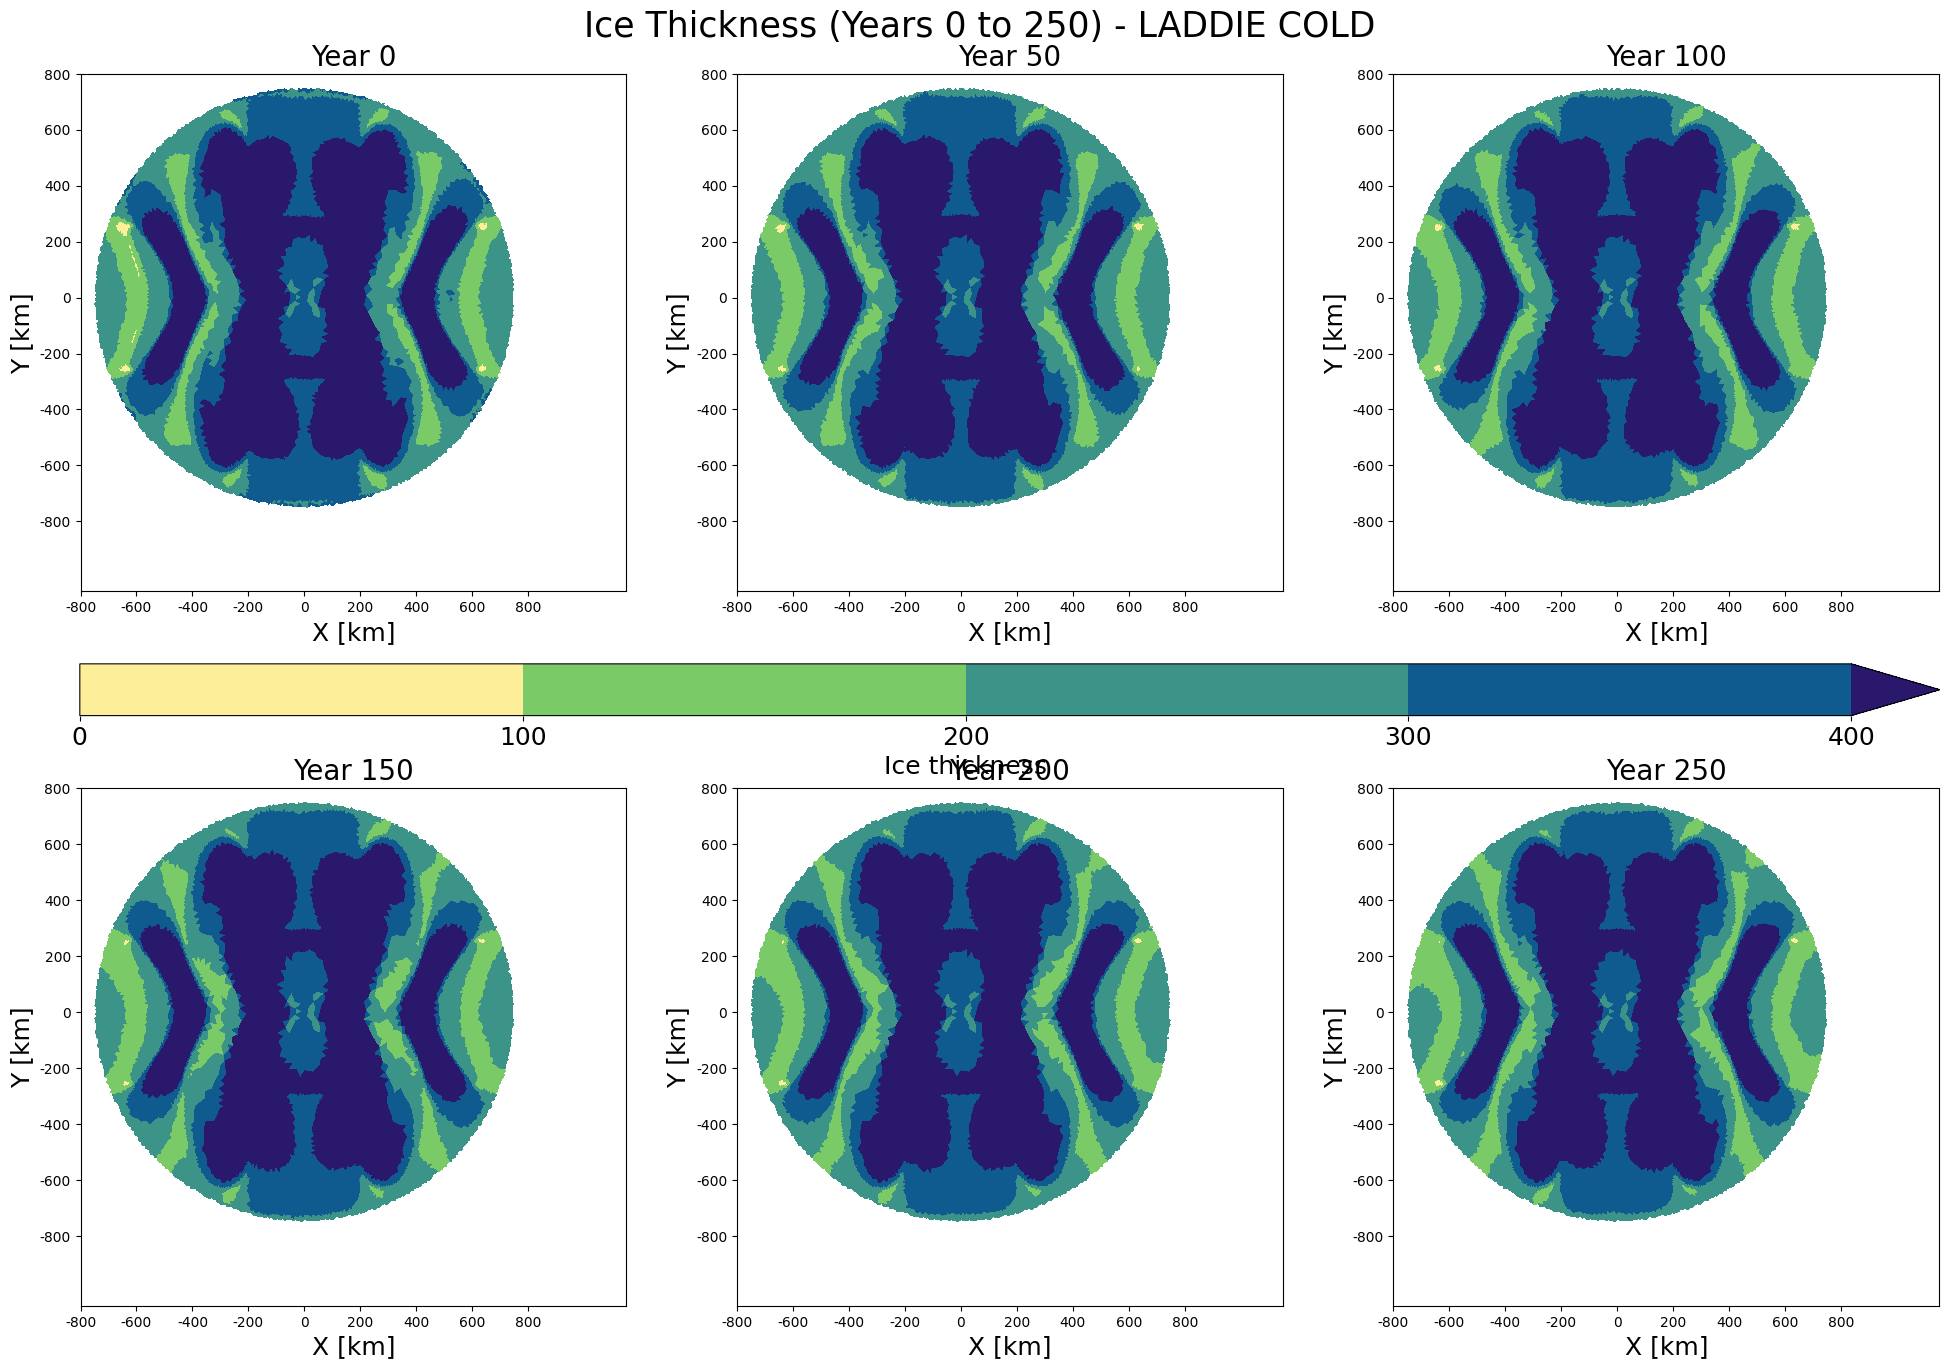

In [53]:
# Define colormap and normalization
cmap = cmo.haline_r
bounds = [0, 100, 200, 300, 400]  # Extended to include 0
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

# Get representative colors for each range
solid_colors = {
    '0-100': cmap(norm(50)),      # Midpoint of 0-100 range
    '100-200': cmap(norm(150)),   # Midpoint of 100-200 range
    '200-300': cmap(norm(250)),   # Midpoint of 200-300 range
    '300-400': cmap(norm(350)),   # Midpoint of 300-400 range
    '>400': cmap(norm(450))       # Slightly beyond max bound
}

# Convert to hex codes
hex_colors = {k: mpl.colors.to_hex(v) for k,v in solid_colors.items()}

ranges = [
    (0, 100),
    (100, 200),
    (200, 300),
    (300, 400),
]
# Create figure #############################################################################################################################
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.1, 1], hspace=0.2, wspace=0.2)

axes = []
for i in range(6):
    if i < 3:
        axes.append(plt.subplot(gs[0, i]))  # First row
    else:
        axes.append(plt.subplot(gs[2, i-3]))  # Third row

legend_handles = [
    Patch(color=solid_colors['0-100'], label='0-100 m'),
    Patch(color=solid_colors['100-200'], label='100-200 m'),
    Patch(color=solid_colors['200-300'], label='200-300 m'),
    Patch(color=solid_colors['300-400'], label='300-400 m'),
    Patch(color=solid_colors['>400'], label='>400 m')
]



# Plot ice thickness
c0 = axes[0].tripcolor(triang1, Hi1[0].where(mask_ocean1),norm = norm, cmap=cmap)
c50 = axes[1].tripcolor(triang2, Hi2[4].where(mask_ocean2),norm = norm, cmap=cmap)
c100= axes[2].tripcolor(triang2, Hi2[9].where(mask_ocean2),norm = norm, cmap=cmap)
c150 = axes[3].tripcolor(triang3, Hi3[0].where(mask_ocean3),norm = norm, cmap=cmap)
c200 = axes[4].tripcolor(triang3, Hi3[5].where(mask_ocean3),norm = norm, cmap=cmap)
c250 = axes[5].tripcolor(triang3, Hi3[10].where(mask_ocean3),norm = norm, cmap=cmap)

#axes[0].plot(GL1[:, 0], GL1[:, 1], 'k--', linewidth=2, label='Grounding Line')
#axes[1].plot(GL2[:, 0], GL2[:, 1], 'k--', linewidth=2, label='Grounding Line')
#axes[2].plot(GL2[:, 0], GL2[:, 1], 'k--', linewidth=2, label='Grounding Line')
#axes[3].plot(GL2[:, 0], GL2[:, 1], 'k--', linewidth=2, label='Grounding Line')
#axes[4].plot(GL3[:, 0], GL3[:, 1], 'k--', linewidth=2, label='Grounding Line')
#axes[5].plot(GL3[:, 0], GL3[:, 1], 'k--', linewidth=2, label='Grounding Line')

for i in range(6):
    ax = axes[i]
    # Set main plot properties
    ax.set_title(f'Year {year[i]}', fontsize=tfs)
    ax.set_xlabel('X [km]', fontsize=afs)
    ax.set_ylabel('Y [km]', fontsize=afs)
    ax.set_xticks(np.arange(-n, n + 1, 200000))
    ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_yticks(np.arange(-n, n + 1, 200000))
    ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_xlim(-n, m+250000)
    ax.set_ylim(-m-150000, n)
    ax.set_aspect('equal')

plt.suptitle('Ice Thickness (Years 0 to 250) - LADDIE COLD', fontsize=tfs+5, y=0.92)  

# Add colorbar using the middle row of the gridspec
cbar_ax = plt.subplot(gs[1, :])  # Middle row, all columns
cbar = fig.colorbar(c0, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Ice thickness', fontsize=afs)
cbar.ax.tick_params(labelsize=afs)

plt.tight_layout()
plt.show()

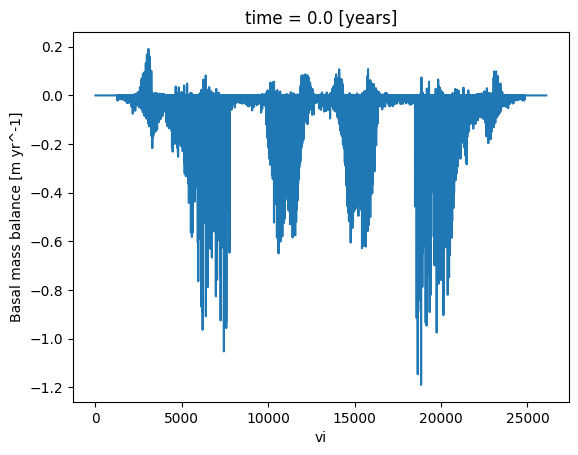

In [45]:
BMB1[0].plot()

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_18304/2219630598.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


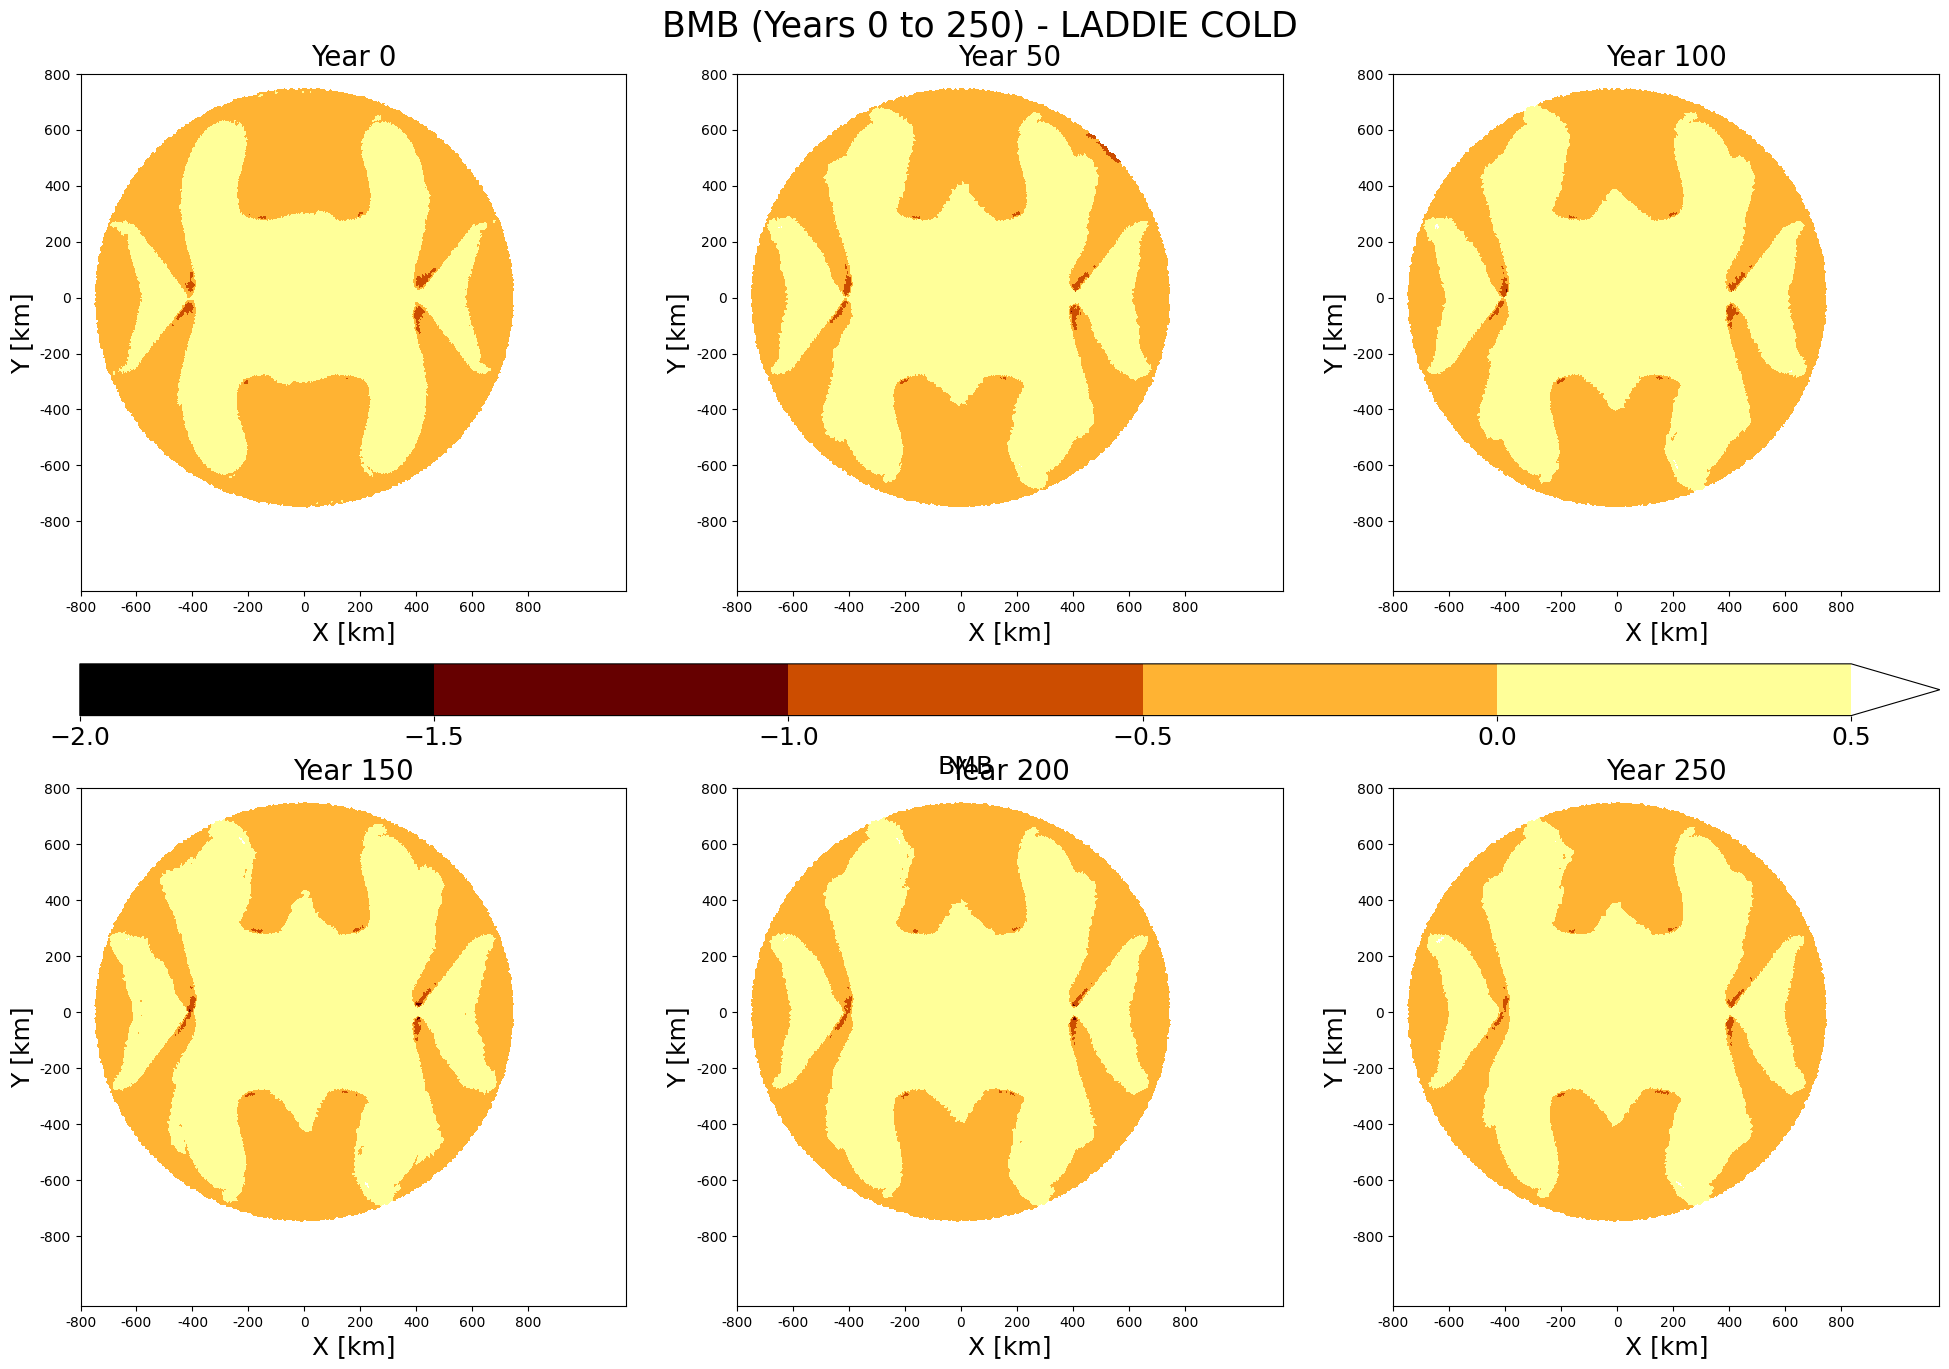

In [50]:
# Define colormap and normalization
cmap = mpl.colormaps['afmhot']
bounds = [-2, -1.5, -1, -0.5,0, 0.5]    # -20, -18, -16, -14, 12, -10 , -8, 
#bounds = [-6, -4, -2, 0, 2]   
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

# Create figure
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.1, 1], hspace=0.2, wspace=0.2)

axes = []
for i in range(6):
    if i < 3:
        axes.append(plt.subplot(gs[0, i]))  # First row
    else:
        axes.append(plt.subplot(gs[2, i-3]))  # Third row


# Plot ice thickness
c0 = axes[0].tripcolor(triang1, BMB1[0].where(mask_ocean1),norm = norm, cmap=cmap)
c50 = axes[1].tripcolor(triang2, BMB2[4].where(mask_ocean2),norm = norm, cmap=cmap)
c100= axes[2].tripcolor(triang2, BMB2[9].where(mask_ocean2),norm = norm, cmap=cmap)
c150 = axes[3].tripcolor(triang3, BMB3[0].where(mask_ocean3),norm = norm, cmap=cmap)
c200 = axes[4].tripcolor(triang3, BMB3[5].where(mask_ocean3),norm = norm, cmap=cmap)
c250 = axes[5].tripcolor(triang3, BMB3[10].where(mask_ocean3),norm = norm, cmap=cmap)

for i in range(6):
    ax = axes[i]
    # Set main plot properties
    ax.set_title(f'Year {year[i]}', fontsize=tfs)
    ax.set_xlabel('X [km]', fontsize=afs)
    ax.set_ylabel('Y [km]', fontsize=afs)
    ax.set_xticks(np.arange(-n, n + 1, 200000))
    ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_yticks(np.arange(-n, n + 1, 200000))
    ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_xlim(-n, m+250000)
    ax.set_ylim(-m-150000, n)
    ax.set_aspect('equal')

plt.suptitle('BMB (Years 0 to 250) - LADDIE COLD', fontsize=tfs+5, y=0.92)  

# Add colorbar using the middle row of the gridspec
cbar_ax = plt.subplot(gs[1, :])  # Middle row, all columns
cbar = fig.colorbar(c0, cax=cbar_ax, orientation='horizontal')
cbar.set_label('BMB', fontsize=afs)
cbar.ax.tick_params(labelsize=afs)

plt.tight_layout()
plt.show()

In [47]:
##COLD##
WaQuad1 = xr.open_dataset(path2 + 'main_output_ANT_00001.nc')
WaQuad2 = xr.open_dataset(path2 + 'main_output_ANT_00002.nc')
WaQuad3 = xr.open_dataset(path2 + 'main_output_ANT_00003.nc')
WaQuad4 = xr.open_dataset(path2 + 'main_output_ANT_00004.nc')
WaQuad5 = xr.open_dataset(path2 + 'main_output_ANT_00005.nc')
WaQuad6 = xr.open_dataset(path2 + 'main_output_ANT_00006.nc')
WaQuad7 = xr.open_dataset(path2 + 'main_output_ANT_00007.nc')
WaQuad8 = xr.open_dataset(path2 + 'main_output_ANT_00008.nc')

Hi1w = WaQuad1['Hi']
BMB1w = WaQuad1['BMB']
Va1w = WaQuad1['V']
V1w = Va1w.T
Tria1w = WaQuad1['Tri'] - 1  
Tri1w = Tria1w.T
triang1w = tri.Triangulation(V1w[:, 0], V1w[:, 1], Tri1w)

Hi2w = WaQuad2['Hi']
BMB2w = WaQuad2['BMB']
Va2w = WaQuad2['V']
V2w = Va2w.T
Tria2w = WaQuad2['Tri'] - 1  
Tri2w = Tria2w.T
triang2w = tri.Triangulation(V2w[:, 0], V2w[:, 1], Tri2w)

Hi3w = WaQuad3['Hi']
BMB3w = WaQuad3['BMB']
Va3w = WaQuad3['V']
V3w = Va3w.T
Tria3w = WaQuad3['Tri'] - 1  
Tri3w = Tria3w.T
triang3w = tri.Triangulation(V3w[:, 0], V3w[:, 1], Tri3w)

Hi4w = WaQuad4['Hi']
BMB4w = WaQuad4['BMB']
Va4w = WaQuad4['V']
V4w = Va4w.T
Tria4w = WaQuad4['Tri'] - 1  
Tri4w = Tria4w.T
triang4w = tri.Triangulation(V4w[:, 0], V4w[:, 1], Tri4w)

Hi5w = WaQuad5['Hi']
BMB5w = WaQuad5['BMB']
Va5w = WaQuad5['V']
V5w = Va5w.T
Tria5w = WaQuad5['Tri'] - 1  
Tri5w = Tria5w.T
triang5w = tri.Triangulation(V5w[:, 0], V5w[:, 1], Tri5w)

Hi6w = WaQuad6['Hi']
BMB6w = WaQuad6['BMB']
Va6w = WaQuad6['V']
V6w = Va6w.T
Tria6w = WaQuad6['Tri'] - 1  
Tri6w = Tria6w.T
triang6w = tri.Triangulation(V6w[:, 0], V6w[:, 1], Tri6w)

Hi7w = WaQuad7['Hi']
BMB7w = WaQuad7['BMB']
Va7w = WaQuad7['V']
V7w = Va7w.T
Tria7w = WaQuad7['Tri'] - 1  
Tri7w = Tria7w.T
triang7w = tri.Triangulation(V7w[:, 0], V7w[:, 1], Tri7w)

Hi8w = WaQuad8['Hi']
BMB8w = WaQuad8['BMB']
Va8w = WaQuad8['V']
V8w = Va8w.T
Tria8w = WaQuad8['Tri'] - 1  
Tri8w = Tria8w.T
triang8w = tri.Triangulation(V8w[:, 0], V8w[:, 1], Tri8w)

distances1w = np.sqrt(V1w[:, 0]**2 + V1w[:, 1]**2)
mask_ocean1w = distances1w <= radius

distances2w = np.sqrt(V2w[:, 0]**2 + V2w[:, 1]**2)
mask_ocean2w = distances2w <= radius

distances3w = np.sqrt(V3w[:, 0]**2 + V3w[:, 1]**2)
mask_ocean3w = distances3w <= radius

distances4w = np.sqrt(V4w[:, 0]**2 + V4w[:, 1]**2)
mask_ocean4w = distances4w <= radius

distances5w = np.sqrt(V5w[:, 0]**2 + V5w[:, 1]**2)
mask_ocean5w = distances5w <= radius

distances6w = np.sqrt(V6w[:, 0]**2 + V6w[:, 1]**2)
mask_ocean6w = distances6w <= radius

distances7w = np.sqrt(V7w[:, 0]**2 + V7w[:, 1]**2)
mask_ocean7w = distances7w <= radius

distances8w = np.sqrt(V8w[:, 0]**2 + V8w[:, 1]**2)
mask_ocean8w = distances8w <= radius

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_18304/3095860173.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


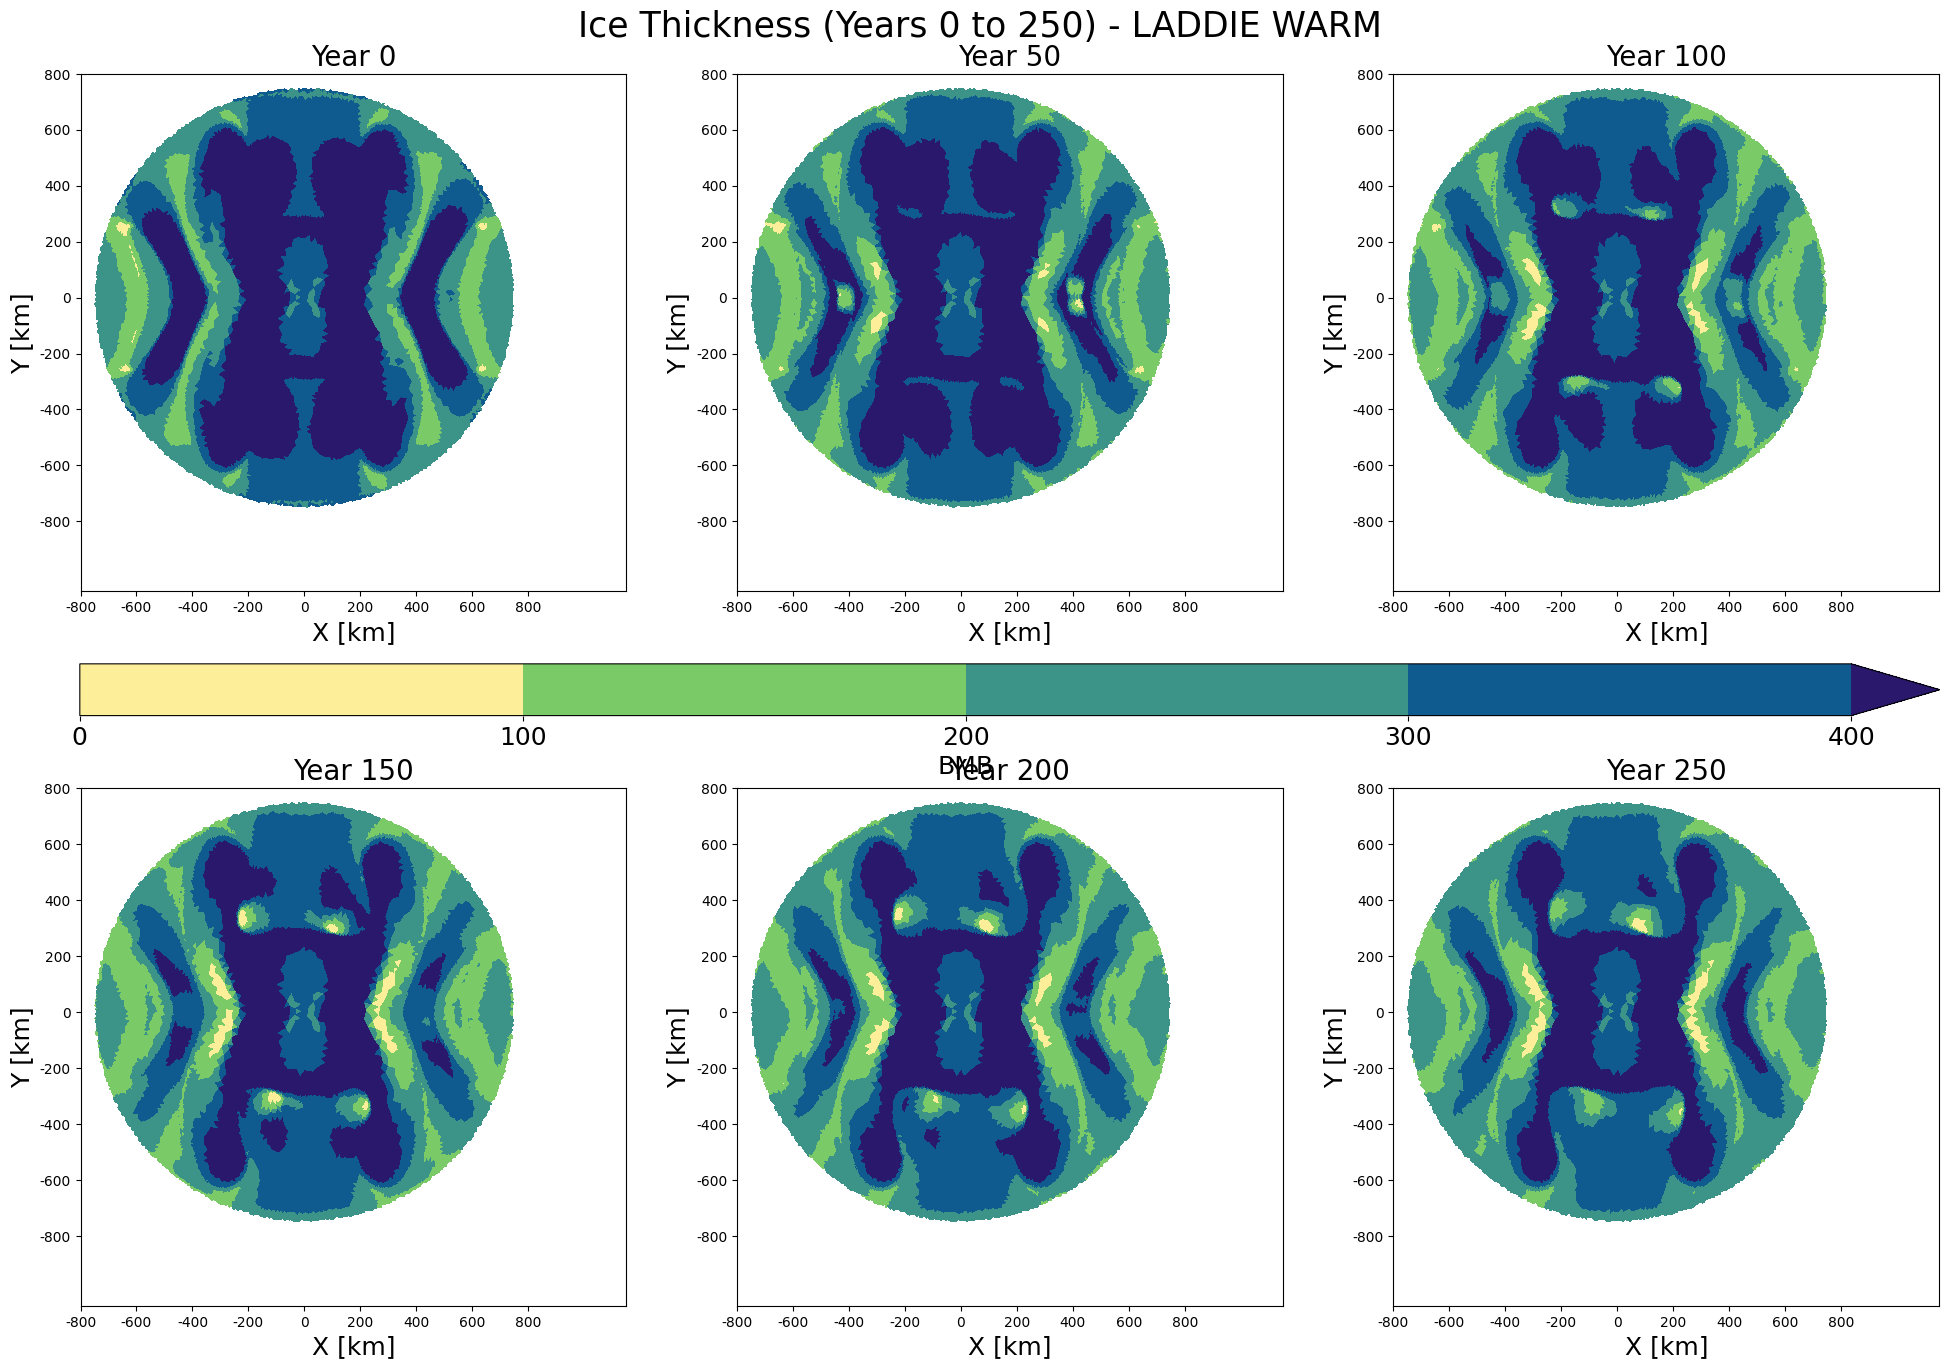

In [54]:
# Define colormap and normalization
cmap = cmo.haline_r
bounds = [0, 100, 200, 300, 400]  # Extended to include 0
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

# Get representative colors for each range
solid_colors = {
    '0-100': cmap(norm(50)),      # Midpoint of 0-100 range
    '100-200': cmap(norm(150)),   # Midpoint of 100-200 range
    '200-300': cmap(norm(250)),   # Midpoint of 200-300 range
    '300-400': cmap(norm(350)),   # Midpoint of 300-400 range
    '>400': cmap(norm(450))       # Slightly beyond max bound
}

# Convert to hex codes
hex_colors = {k: mpl.colors.to_hex(v) for k,v in solid_colors.items()}

ranges = [
    (0, 100),
    (100, 200),
    (200, 300),
    (300, 400),
]
# Create figure #############################################################################################################################
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.1, 1], hspace=0.2, wspace=0.2)

axes = []
for i in range(6):
    if i < 3:
        axes.append(plt.subplot(gs[0, i]))  # First row
    else:
        axes.append(plt.subplot(gs[2, i-3]))  # Third row

legend_handles = [
    Patch(color=solid_colors['0-100'], label='0-100 m'),
    Patch(color=solid_colors['100-200'], label='100-200 m'),
    Patch(color=solid_colors['200-300'], label='200-300 m'),
    Patch(color=solid_colors['300-400'], label='300-400 m'),
    Patch(color=solid_colors['>400'], label='>400 m')
]



# Plot ice thickness
c0 = axes[0].tripcolor(triang1w, Hi1w[0].where(mask_ocean1w),norm = norm, cmap=cmap)
c50 = axes[1].tripcolor(triang5w, Hi5w[0].where(mask_ocean5w),norm = norm, cmap=cmap)
c100= axes[2].tripcolor(triang6w, Hi6w[0].where(mask_ocean6w),norm = norm, cmap=cmap)
c150 = axes[3].tripcolor(triang7w, Hi7w[0].where(mask_ocean7w),norm = norm, cmap=cmap)
c200 = axes[4].tripcolor(triang7w, Hi7w[5].where(mask_ocean7w),norm = norm, cmap=cmap)
c250 = axes[5].tripcolor(triang8w, Hi8w[0].where(mask_ocean8w),norm = norm, cmap=cmap)

for i in range(6):
    ax = axes[i]
    # Set main plot properties
    ax.set_title(f'Year {year[i]}', fontsize=tfs)
    ax.set_xlabel('X [km]', fontsize=afs)
    ax.set_ylabel('Y [km]', fontsize=afs)
    ax.set_xticks(np.arange(-n, n + 1, 200000))
    ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_yticks(np.arange(-n, n + 1, 200000))
    ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_xlim(-n, m+250000)
    ax.set_ylim(-m-150000, n)
    ax.set_aspect('equal')

plt.suptitle('Ice Thickness (Years 0 to 250) - LADDIE WARM', fontsize=tfs+5, y=0.92) 

cbar_ax = plt.subplot(gs[1, :])  # Middle row, all columns
cbar = fig.colorbar(c0, cax=cbar_ax, orientation='horizontal')
cbar.set_label('BMB', fontsize=afs)
cbar.ax.tick_params(labelsize=afs)

plt.tight_layout()
plt.show()

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_18304/3602599023.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


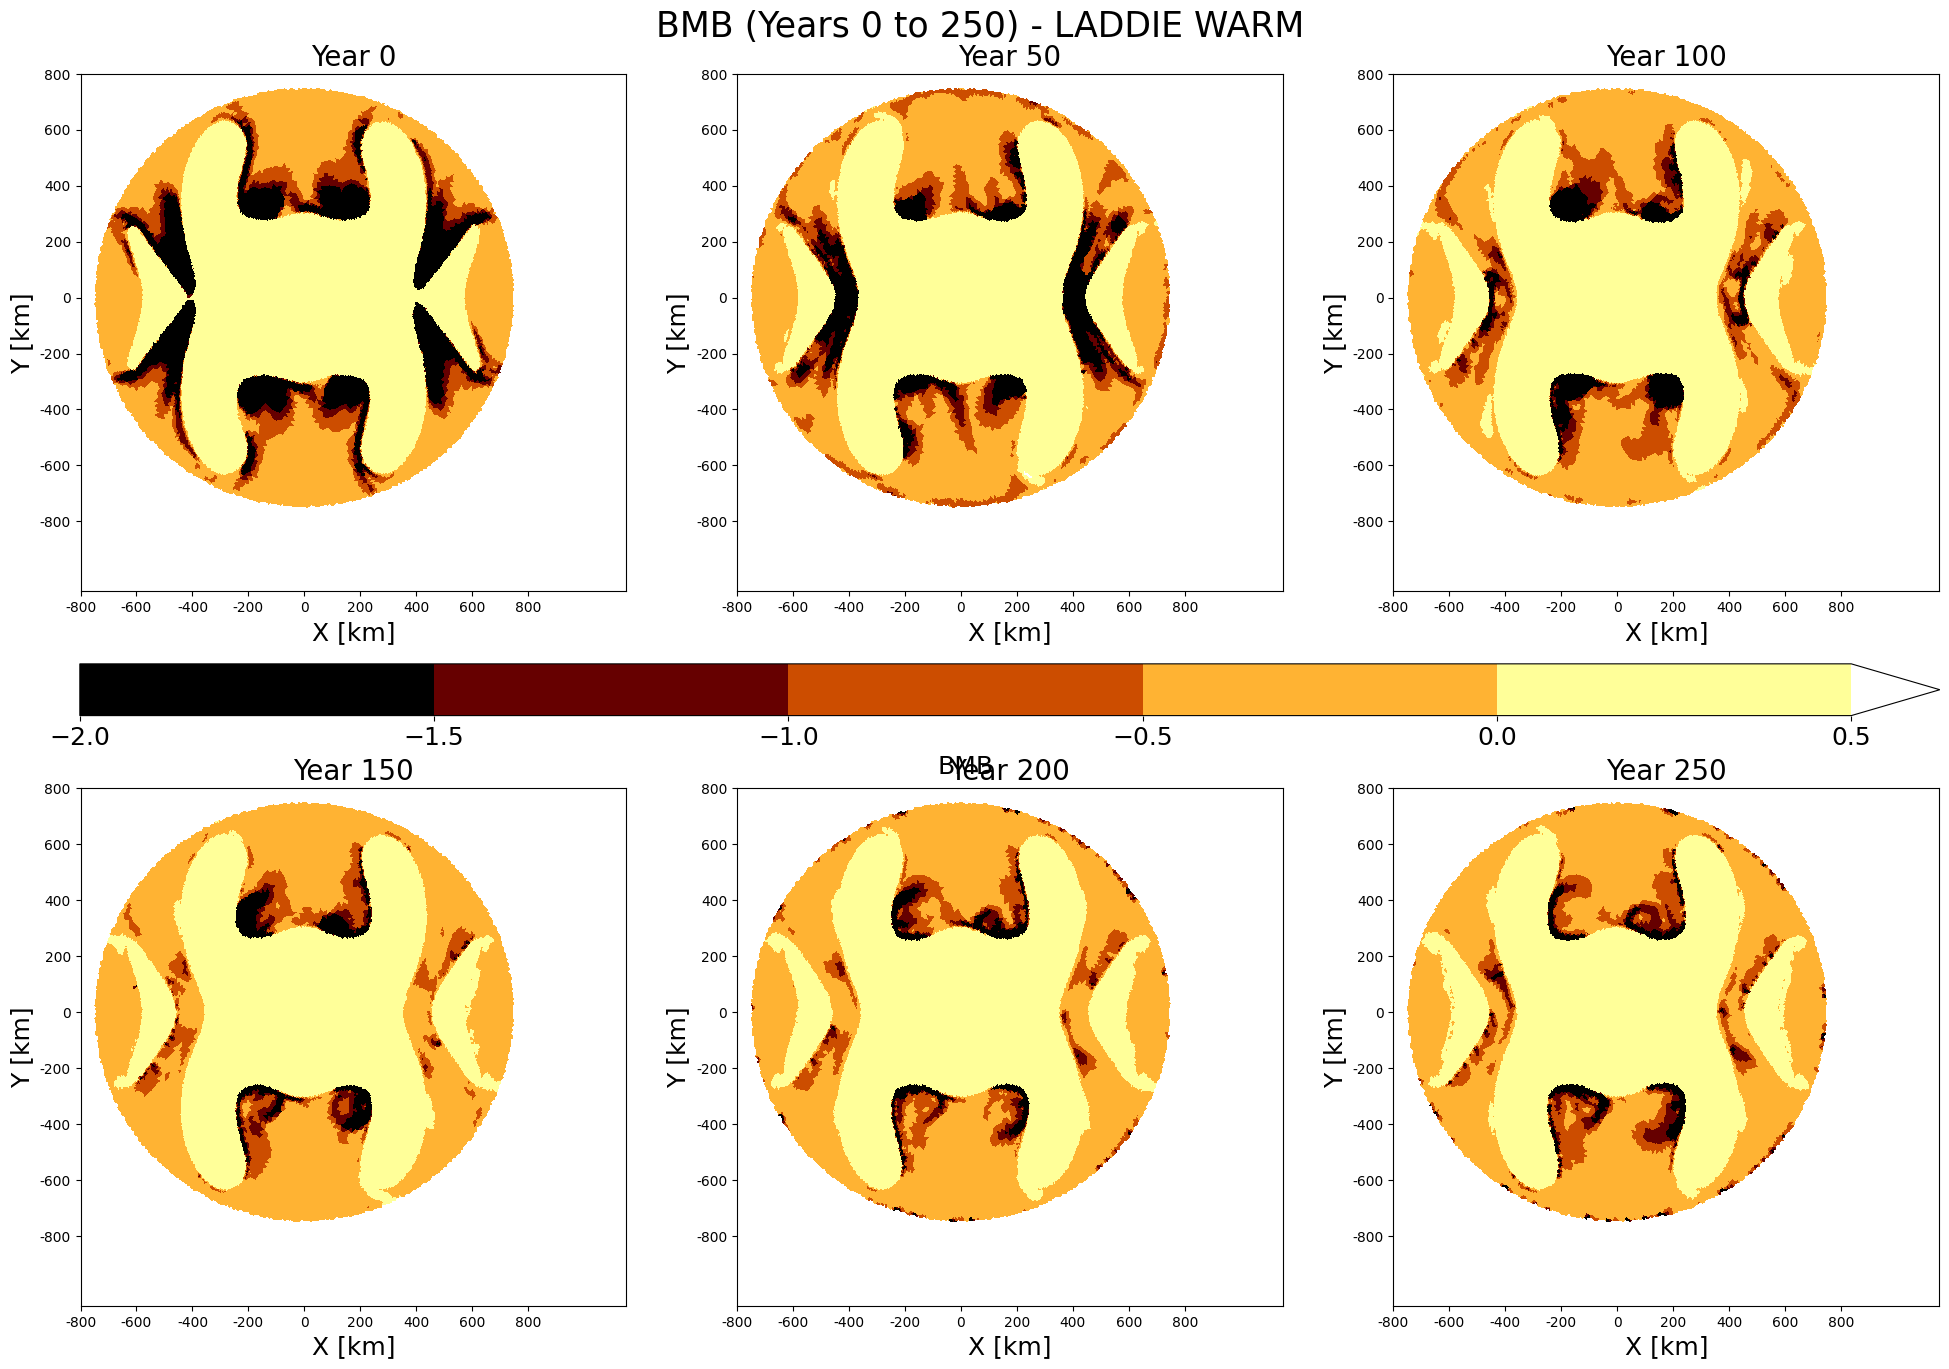

In [55]:
# Define colormap and normalization
cmap = mpl.colormaps['afmhot']
bounds = [-2, -1.5, -1, -0.5,0, 0.5]    # -20, -18, -16, -14, 12, -10 , -8, 
#bounds = [-6, -4, -2, 0, 2]     # -20, -18, -16, -14, 12, -10 , -8, 
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

# Create figure
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.1, 1], hspace=0.2, wspace=0.2)

axes = []
for i in range(6):
    if i < 3:
        axes.append(plt.subplot(gs[0, i]))  # First row
    else:
        axes.append(plt.subplot(gs[2, i-3]))  # Third row

# Plot ice thickness
c0 = axes[0].tripcolor(triang1w, BMB1w[0].where(mask_ocean1w),norm = norm, cmap=cmap)
c50 = axes[1].tripcolor(triang5w, BMB5w[0].where(mask_ocean5w),norm = norm, cmap=cmap)
c100= axes[2].tripcolor(triang6w, BMB6w[0].where(mask_ocean6w),norm = norm, cmap=cmap)
c150 = axes[3].tripcolor(triang7w, BMB7w[0].where(mask_ocean7w),norm = norm, cmap=cmap)
c200 = axes[4].tripcolor(triang7w, BMB7w[5].where(mask_ocean7w),norm = norm, cmap=cmap)
c250 = axes[5].tripcolor(triang8w, BMB8w[0].where(mask_ocean8w),norm = norm, cmap=cmap)

for i in range(6):
    ax = axes[i]
    # Set main plot properties
    ax.set_title(f'Year {year[i]}', fontsize=tfs)
    ax.set_xlabel('X [km]', fontsize=afs)
    ax.set_ylabel('Y [km]', fontsize=afs)
    ax.set_xticks(np.arange(-n, n + 1, 200000))
    ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_yticks(np.arange(-n, n + 1, 200000))
    ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_xlim(-n, m+250000)
    ax.set_ylim(-m-150000, n)
    ax.set_aspect('equal')

plt.suptitle('BMB (Years 0 to 250) - LADDIE WARM', fontsize=tfs+5, y=0.92)  

# Add colorbar using the middle row of the gridspec
cbar_ax = plt.subplot(gs[1, :])  # Middle row, all columns
cbar = fig.colorbar(c0, cax=cbar_ax, orientation='horizontal')
cbar.set_label('BMB', fontsize=afs)
cbar.ax.tick_params(labelsize=afs)

plt.tight_layout()
plt.show()

IndexError: range object index out of range

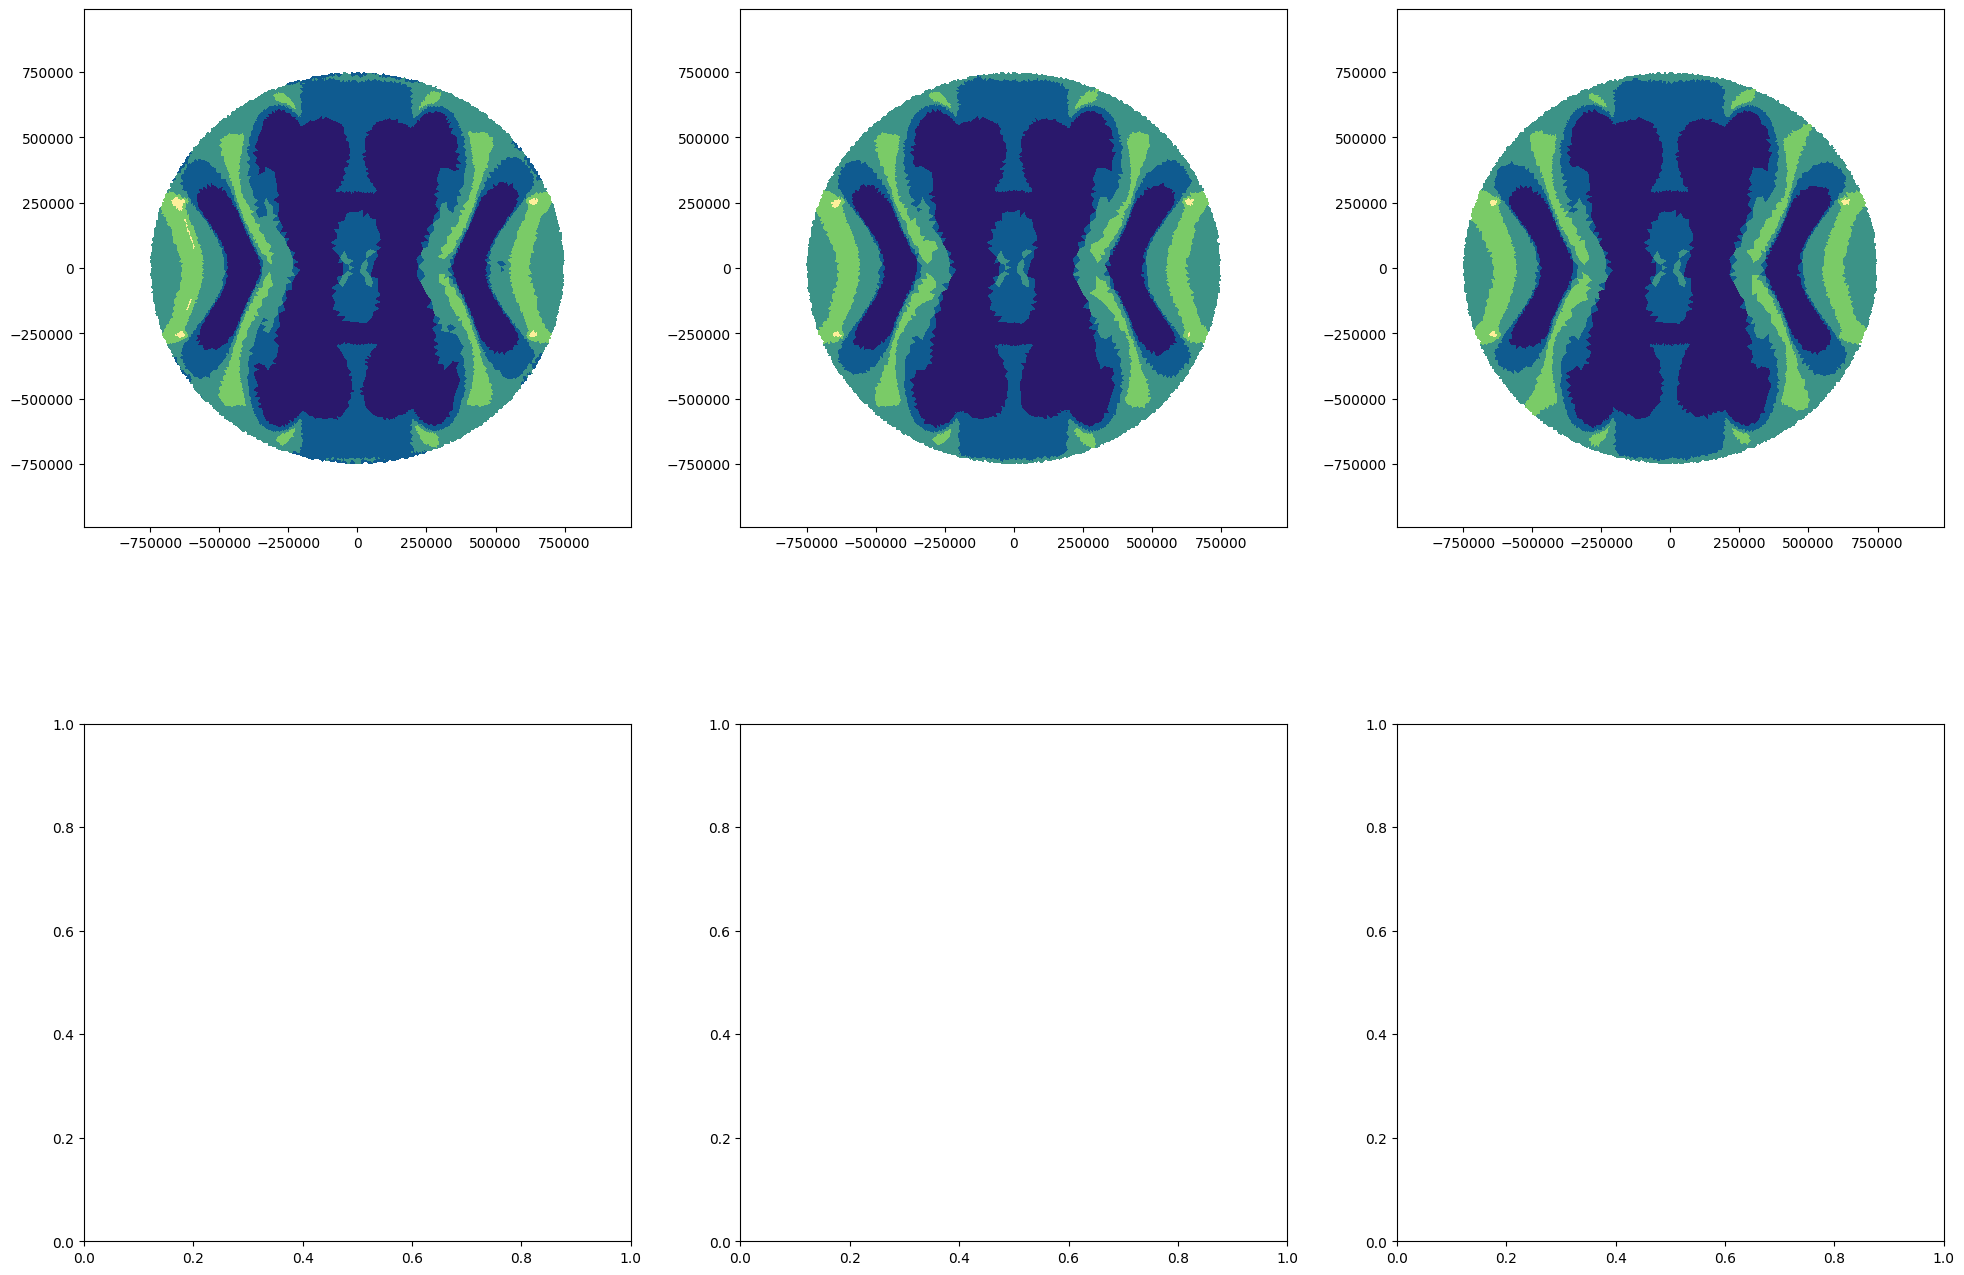

In [41]:
# Define colormap and normalization
cmap = cmo.haline_r
bounds = [0, 100, 200, 300, 400]  # Extended to include 0
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

# Get representative colors for each range
solid_colors = {
    '0-100': cmap(norm(50)),      # Midpoint of 0-100 range
    '100-200': cmap(norm(150)),   # Midpoint of 100-200 range
    '200-300': cmap(norm(250)),   # Midpoint of 200-300 range
    '300-400': cmap(norm(350)),   # Midpoint of 300-400 range
    '>400': cmap(norm(450))       # Slightly beyond max bound
}

# Convert to hex codes
hex_colors = {k: mpl.colors.to_hex(v) for k,v in solid_colors.items()}

ranges = [
    (0, 100),
    (100, 200),
    (200, 300),
    (300, 400),
]
# Create figure #############################################################################################################################
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.1, 1], hspace=0.2, wspace=0.2)

axes = []
for i in range(6):
    if i < 3:
        axes.append(plt.subplot(gs[0, i]))  # First row
    else:
        axes.append(plt.subplot(gs[2, i-3]))  # Third row

legend_handles = [
    Patch(color=solid_colors['0-100'], label='0-100 m'),
    Patch(color=solid_colors['100-200'], label='100-200 m'),
    Patch(color=solid_colors['200-300'], label='200-300 m'),
    Patch(color=solid_colors['300-400'], label='300-400 m'),
    Patch(color=solid_colors['>400'], label='>400 m')
]



# Plot ice thickness
c0 = axes[0].tripcolor(triang1, Hi1[0].where(mask_ocean1),norm = norm, cmap=cmap)
c50 = axes[1].tripcolor(triang2, Hi2[4].where(mask_ocean2),norm = norm, cmap=cmap)
c100= axes[2].tripcolor(triang2, Hi2[9].where(mask_ocean2),norm = norm, cmap=cmap)
c150 = axes[3].tripcolor(triang2, Hi2[14].where(mask_ocean2),norm = norm, cmap=cmap)
c200 = axes[4].tripcolor(triang3, Hi3[1].where(mask_ocean3),norm = norm, cmap=cmap)
c250 = axes[5].tripcolor(triang3, Hi3[6].where(mask_ocean3),norm = norm, cmap=cmap)

for i in range(6):
    ax = axes[i]
    # Set main plot properties
    ax.set_title(f'Year {year[i]}', fontsize=tfs)
    ax.set_xlabel('X [km]', fontsize=afs)
    ax.set_ylabel('Y [km]', fontsize=afs)
    ax.set_xticks(np.arange(-n, n + 1, 200000))
    ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_yticks(np.arange(-n, n + 1, 200000))
    ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_xlim(-n, m+250000)
    ax.set_ylim(-m-150000, n)
    ax.set_aspect('equal')

# Add colorbar using the middle row of the gridspec
cbar_ax = plt.subplot(gs[1, :])  # Middle row, all columns
cbar = fig.colorbar(c0, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Ice thickness', fontsize=afs)
cbar.ax.tick_params(labelsize=afs)

plt.suptitle('Ice Thickness Evolution each decade (Years 0 to 250) - QUADRATIC COLD', fontsize=tfs+5, y=0.92)  

plt.tight_layout()
plt.show()

In [ ]:
# Define colormap and normalization
cmap = cmo.haline_r
bounds = [0, 100, 200, 300, 400]  # Extended to include 0
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

# Get representative colors for each range
solid_colors = {
    '0-100': cmap(norm(50)),      # Midpoint of 0-100 range
    '100-200': cmap(norm(150)),   # Midpoint of 100-200 range
    '200-300': cmap(norm(250)),   # Midpoint of 200-300 range
    '300-400': cmap(norm(350)),   # Midpoint of 300-400 range
    '>400': cmap(norm(450))       # Slightly beyond max bound
}

# Convert to hex codes
hex_colors = {k: mpl.colors.to_hex(v) for k,v in solid_colors.items()}

ranges = [
    (0, 100),
    (100, 200),
    (200, 300),
    (300, 400),
]
# Create figure #############################################################################################################################
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.1, 1], hspace=0.2, wspace=0.2)

axes = []
for i in range(6):
    if i < 3:
        axes.append(plt.subplot(gs[0, i]))  # First row
    else:
        axes.append(plt.subplot(gs[2, i-3]))  # Third row

legend_handles = [
    Patch(color=solid_colors['0-100'], label='0-100 m'),
    Patch(color=solid_colors['100-200'], label='100-200 m'),
    Patch(color=solid_colors['200-300'], label='200-300 m'),
    Patch(color=solid_colors['300-400'], label='300-400 m'),
    Patch(color=solid_colors['>400'], label='>400 m')
]

# Plot ice thickness
c0 = axes[0].tripcolor(triang1, Hi1[1].where(mask_ocean ),norm = norm, cmap=cmap)
"""

    # Plot grounding line
    #GL = Lad1['grounding_line'][year]
    ax.plot(GL[0, :], GL[1, :], color='black', linewidth=3, label='Grounding Line')

    # Calculate area-weighted percentages
    percentages = calculate_area_percentages(V, Hi_l[year].where(mask0 & mask_ocean), ranges)
    
    # Prepare pie chart data
    sizes = percentages
    colors = list(solid_colors.values())
    
    # Add pie chart in bottom right
    pie_ax = inset_axes(ax, width=1.6, height=1.6, loc='lower right',
                       bbox_to_anchor=(0.97, 0.0), bbox_transform=ax.transAxes)
    
    if np.sum(sizes) > 0:
        wedges, texts = pie_ax.pie(sizes, colors=colors, startangle=90,
                                 wedgeprops=dict(width=0.5, edgecolor='w'))
        
        # Add percentage labels
        for j, wedge in enumerate(wedges):
            if sizes[j] > 5:  # Only show label if percentage > 5%
                angle = (wedge.theta2 - wedge.theta1)/2 + wedge.theta1
                x = 1.3* np.cos(np.deg2rad(angle))
                y = 1.2 * np.sin(np.deg2rad(angle))
                pie_ax.text(x, y, f'{sizes[j]:.1f}%', ha='center', va='center', fontsize=10)
    else:
        pie_ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
        pie_ax.set_xticks([])
        pie_ax.set_yticks([])"""
for i in range(6):
    ax = axes[i]
    # Set main plot properties
    ax.set_title(f'Year {year}', fontsize=tfs)
    ax.set_xlabel('X [km]', fontsize=afs)
    ax.set_ylabel('Y [km]', fontsize=afs)
    ax.set_xticks(np.arange(-n, n + 1, 200000))
    ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_yticks(np.arange(-n, n + 1, 200000))
    ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_xlim(-n, m+250000)
    ax.set_ylim(-m-150000, n)
    ax.set_aspect('equal')
"""
ax.legend(loc='upper left', bbox_to_anchor=(-0.07, 1.21), edgecolor='white', fontsize=16, frameon=False)
# Add legend in the middle row
legend_ax = plt.subplot(gs[1, :])
legend_ax.axis('off')
legend = legend_ax.legend(handles=legend_handles, 
                         title='Ice Thickness', 
                         loc='center', 
                         ncol=5,
                         fontsize=16,
                         frameon=False,
                         bbox_to_anchor=(0.40, 0.5),
                         title_fontsize=18)"""

plt.suptitle('Ice Thickness Evolution each decade (Years 0 to 50) - QUADRATIC', fontsize=tfs+5, y=0.92)  

plt.tight_layout()
plt.show()

### Nowork

ValueError: cannot reindex or align along dimension 'vi' because of conflicting dimension sizes: {25610, 26095}

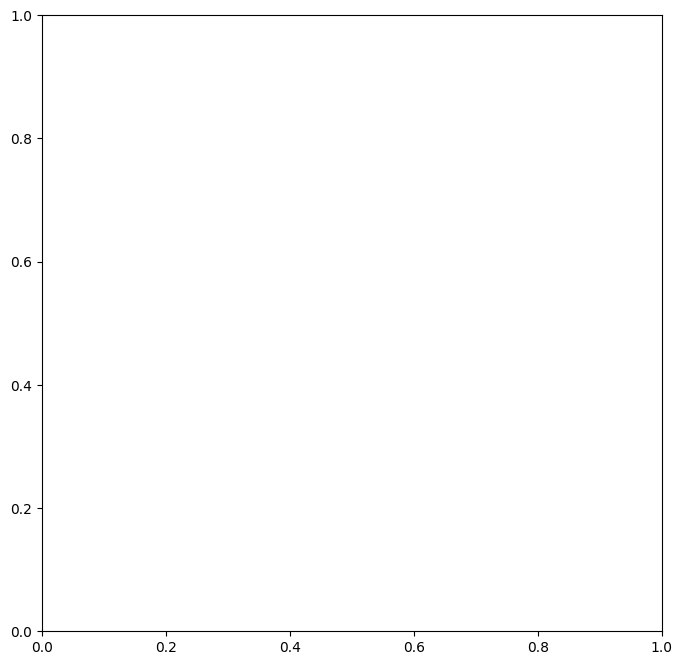

In [25]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 

c0 = ax.tripcolor(triang, (Hilast[-1]-Hi[0])/(Hi[0]).where(mask_ocean), cmap=cmo.balance, vmin=-1, vmax= 0)
cbar = fig.colorbar(c0, ax=ax, **colorbar_kwargs)
cbar.set_label("Ice Thickness Change [m]", fontsize= ctfs) 
ax.set_title('Relative thickness change', fontsize= tfs)

ax.set_xlabel('X [km]', fontsize=afs)
ax.set_ylabel('Y [km]', fontsize=afs)
ax.set_xticks(np.arange(-n, n + 1, 200000))
ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
ax.set_yticks(np.arange(-n, n + 1, 200000))
ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
ax.set_xlim(-n, n)
ax.set_ylim(-n, n)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

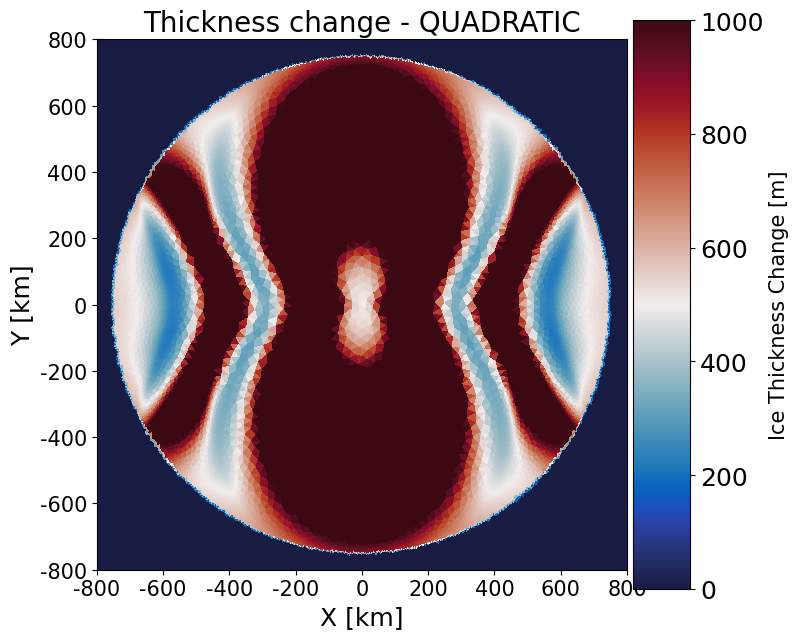

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 

c0 = ax.tripcolor(triang, Hi[0], cmap=cmo.balance, vmin=0, vmax= 1000)
cbar = fig.colorbar(c0, ax=ax, **colorbar_kwargs)
cbar.set_label("Ice Thickness Change [m]", fontsize= ctfs)  # Set fontsize here
cbar.ax.tick_params(labelsize=cbfs)
ax.set_title('Thickness change - QUADRATIC', fontsize=tfs)
#ax.plot([-150000, -150000], [0, 740000], color='black', linestyle='-', linewidth=2)

#ax.text(80000, 100000, 'Halbrane A', fontsize=afs, color='black', ha='center', va='center')
ax.set_xlabel('X [km]', fontsize=afs)
ax.set_ylabel('Y [km]', fontsize=afs)
ax.set_xticks(np.arange(-n, n + 1, 200000))
ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
ax.set_yticks(np.arange(-n, n + 1, 200000))
ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
ax.set_xlim(-n, n)
ax.set_ylim(-n, n)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

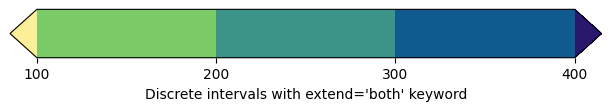

In [14]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')

cmap = cmo.haline_r
bounds = [100, 200, 300, 400]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal',
             label="Discrete intervals with extend='both' keyword")

<xarray.Dataset> Size: 162MB
Dimensions:                     (two: 2, vi: 25610, ci: 32, three: 3,
                                 ti: 50953, ei: 76562, four: 4, vori: 51222,
                                 bin: 11, time: 7, zeta: 12, month: 12,
                                 depth: 16)
Coordinates:
  * time                        (time) float64 56B 190.0 200.0 ... 240.0 250.0
  * zeta                        (zeta) float64 96B 0.0 0.09091 ... 0.9091 1.0
  * month                       (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * depth                       (depth) float64 128B 0.0 100.0 ... 1.5e+03
Dimensions without coordinates: two, vi, ci, three, ti, ei, four, vori, bin
Data variables: (12/76)
    xmin                        float64 8B ...
    xmax                        float64 8B ...
    ymin                        float64 8B ...
    ymax                        float64 8B ...
    tol_dist                    float64 8B ...
    lambda_M                    float64 8B ...
    ...                          ...
    v_base                      (time, ti) float64 3MB ...
    dHb_dt                      (time, vi) float64 1MB ...
    dHib_dt                     (time, vi) float64 1MB ...
    dHs_dt                      (time, vi) float64 1MB ...
    S_ocean                     (time, depth, vi) float64 23MB ...
    T_ocean                     (time, depth, vi) float64 23MB ...
Attributes:
    git commit hash:  b0b9afc5c5d65f2e42a58fd46a8d3b648efe7a3f (with uncommit...

{'0-100': '#fdef9a', '100-200': '#7acb67', '200-300': '#3c9387', '300-400': '#0f5b90', '>400': '#2a186c'}


NameError: name 'Hi_l' is not defined

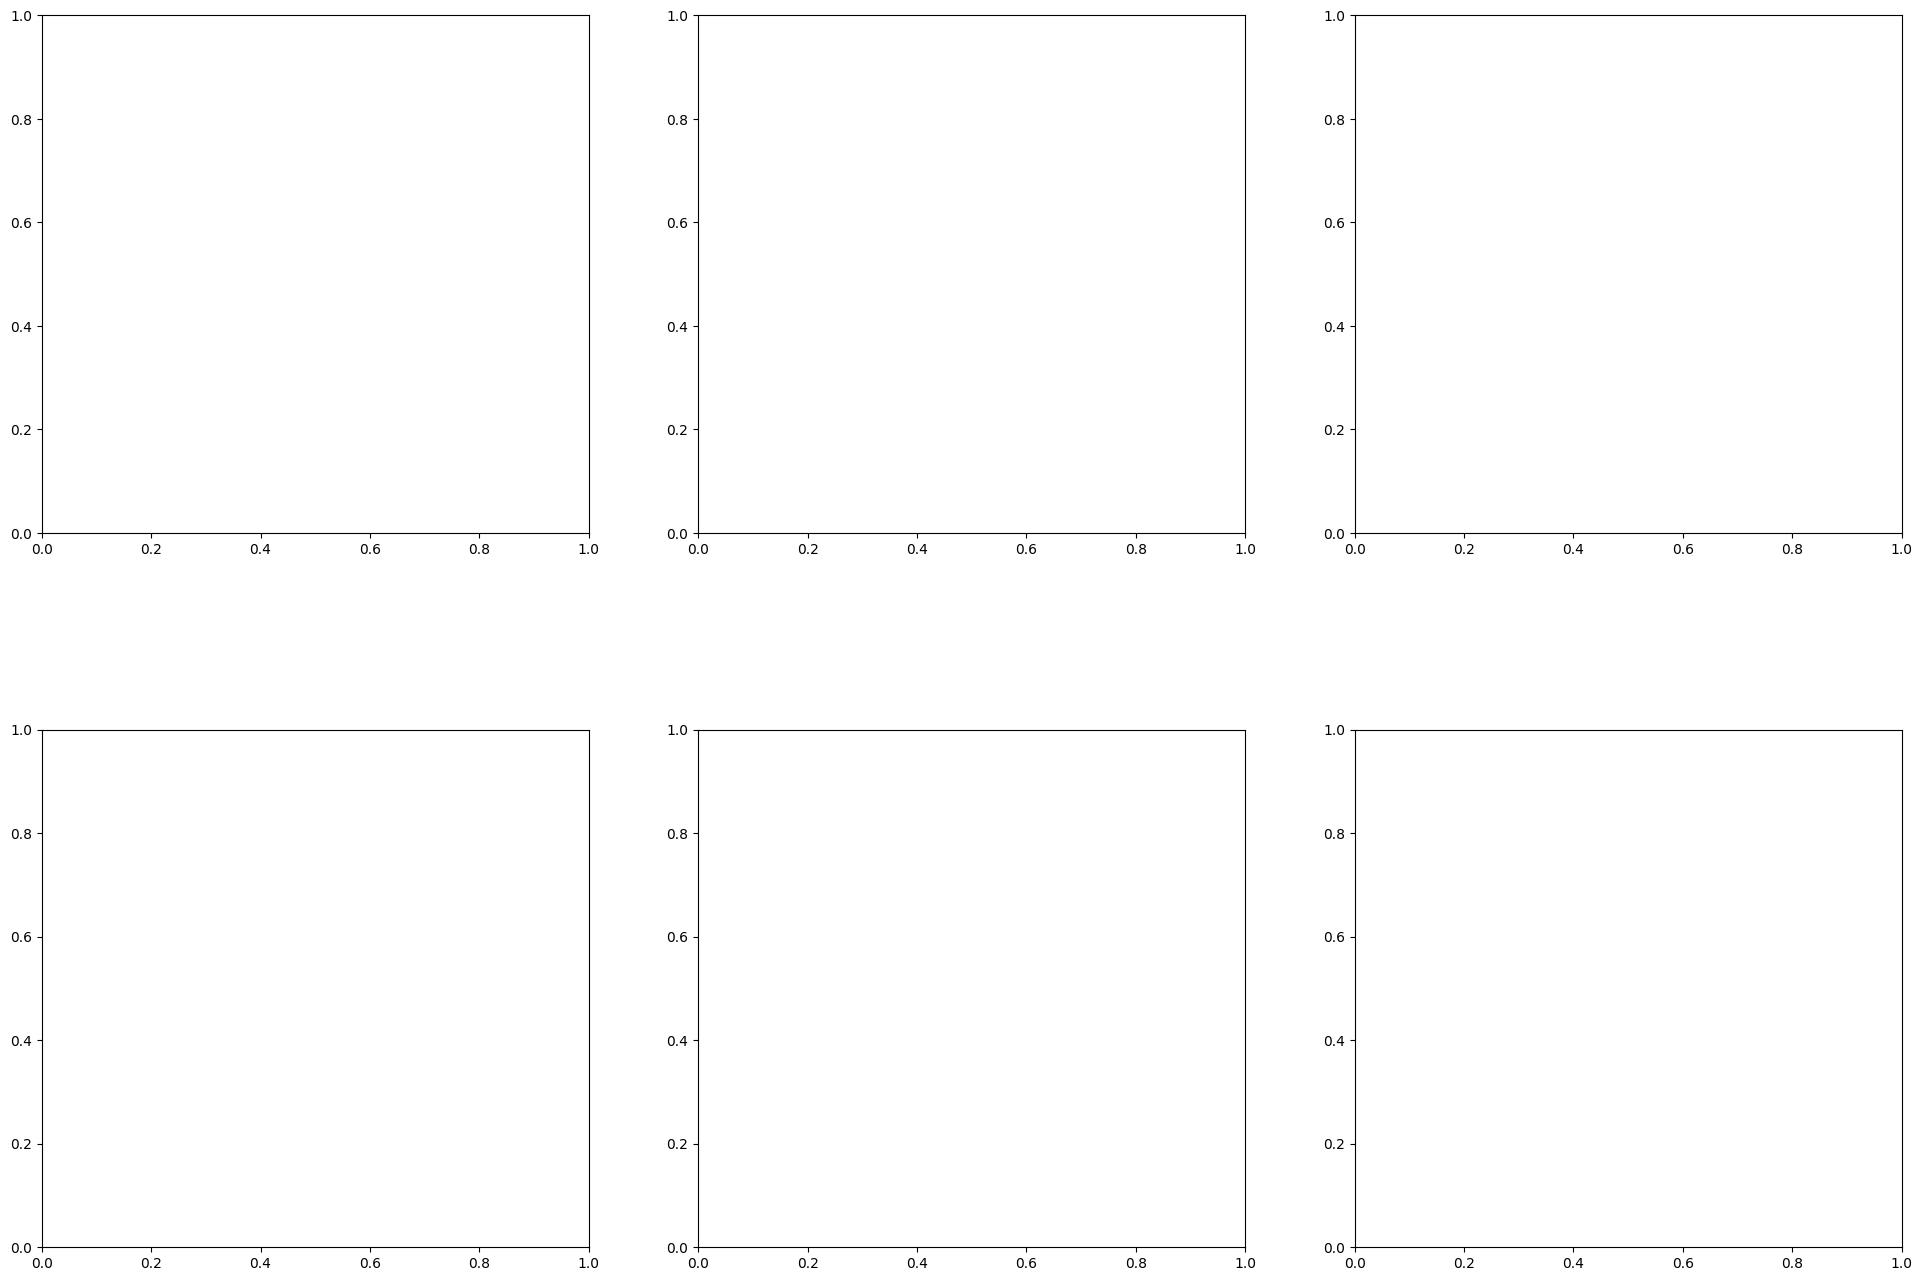

In [ ]:
# Define colormap and normalization
cmap = cmo.haline_r
bounds = [0, 100, 200, 300, 400]  # Extended to include 0
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

# Get representative colors for each range
solid_colors = {
    '0-100': cmap(norm(50)),      # Midpoint of 0-100 range
    '100-200': cmap(norm(150)),   # Midpoint of 100-200 range
    '200-300': cmap(norm(250)),   # Midpoint of 200-300 range
    '300-400': cmap(norm(350)),   # Midpoint of 300-400 range
    '>400': cmap(norm(450))       # Slightly beyond max bound
}

# Convert to hex codes
hex_colors = {k: mpl.colors.to_hex(v) for k,v in solid_colors.items()}
print(hex_colors)

ranges = [
    (0, 100),
    (100, 200),
    (200, 300),
    (300, 400),
]

# Create colormaps
cmap_red = ListedColormap([solid_colors['0-100']])
cmap_orange = ListedColormap([solid_colors['100-200']])
cmap_blue = ListedColormap([solid_colors['200-300']])
cmap_purple = ListedColormap([solid_colors['300-400']])
cmap_grey = ListedColormap([solid_colors['>400']])

# Create figure
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.1, 1], hspace=0.2, wspace=0.2)

axes = []
for i in range(6):
    if i < 3:
        axes.append(plt.subplot(gs[0, i]))  # First row
    else:
        axes.append(plt.subplot(gs[2, i-3]))  # Third row

legend_handles = [
    Patch(color=solid_colors['0-100'], label='0-100 m'),
    Patch(color=solid_colors['100-200'], label='100-200 m'),
    Patch(color=solid_colors['200-300'], label='200-300 m'),
    Patch(color=solid_colors['300-400'], label='300-400 m'),
    Patch(color=solid_colors['>400'], label='>400 m')
]

for i, year in enumerate(years):
    ax = axes[i]
    
    # Plot ice thickness
    c0 = ax.tripcolor(triang, Hi[year].where(mask_ocean ),norm = norm, cmap=cmap)
"""
    # Plot grounding line
    #GL = Lad1['grounding_line'][year]
    ax.plot(GL[0, :], GL[1, :], color='black', linewidth=3, label='Grounding Line')

    # Calculate area-weighted percentages
    percentages = calculate_area_percentages(V, Hi_l[year].where(mask0 & mask_ocean), ranges)
    
    # Prepare pie chart data
    sizes = percentages
    colors = list(solid_colors.values())
    
    # Add pie chart in bottom right
    pie_ax = inset_axes(ax, width=1.6, height=1.6, loc='lower right',
                       bbox_to_anchor=(0.97, 0.0), bbox_transform=ax.transAxes)
    
    if np.sum(sizes) > 0:
        wedges, texts = pie_ax.pie(sizes, colors=colors, startangle=90,
                                 wedgeprops=dict(width=0.5, edgecolor='w'))
        
        # Add percentage labels
        for j, wedge in enumerate(wedges):
            if sizes[j] > 5:  # Only show label if percentage > 5%
                angle = (wedge.theta2 - wedge.theta1)/2 + wedge.theta1
                x = 1.3* np.cos(np.deg2rad(angle))
                y = 1.2 * np.sin(np.deg2rad(angle))
                pie_ax.text(x, y, f'{sizes[j]:.1f}%', ha='center', va='center', fontsize=10)
    else:
        pie_ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
        pie_ax.set_xticks([])
        pie_ax.set_yticks([])"""
    
    # Set main plot properties
    ax.set_title(f'Year {year}', fontsize=tfs)
    ax.set_xlabel('X [km]', fontsize=afs)
    ax.set_ylabel('Y [km]', fontsize=afs)
    ax.set_xticks(np.arange(-n, n + 1, 200000))
    ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_yticks(np.arange(-n, n + 1, 200000))
    ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_xlim(-n, m+250000)
    ax.set_ylim(-m-150000, n)
    ax.set_aspect('equal')
"""
ax.legend(loc='upper left', bbox_to_anchor=(-0.07, 1.21), edgecolor='white', fontsize=16, frameon=False)
# Add legend in the middle row
legend_ax = plt.subplot(gs[1, :])
legend_ax.axis('off')
legend = legend_ax.legend(handles=legend_handles, 
                         title='Ice Thickness', 
                         loc='center', 
                         ncol=5,
                         fontsize=16,
                         frameon=False,
                         bbox_to_anchor=(0.40, 0.5),
                         title_fontsize=18)"""

plt.suptitle('Ice Thickness Evolution each decade (Years 0 to 50) - QUADRATIC', fontsize=tfs+5, y=0.92)  

plt.tight_layout()
plt.show()

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_15880/2214422446.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(-0.01, 1.146), edgecolor='white', fontsize=16, frameon=False)
/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_15880/2214422446.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


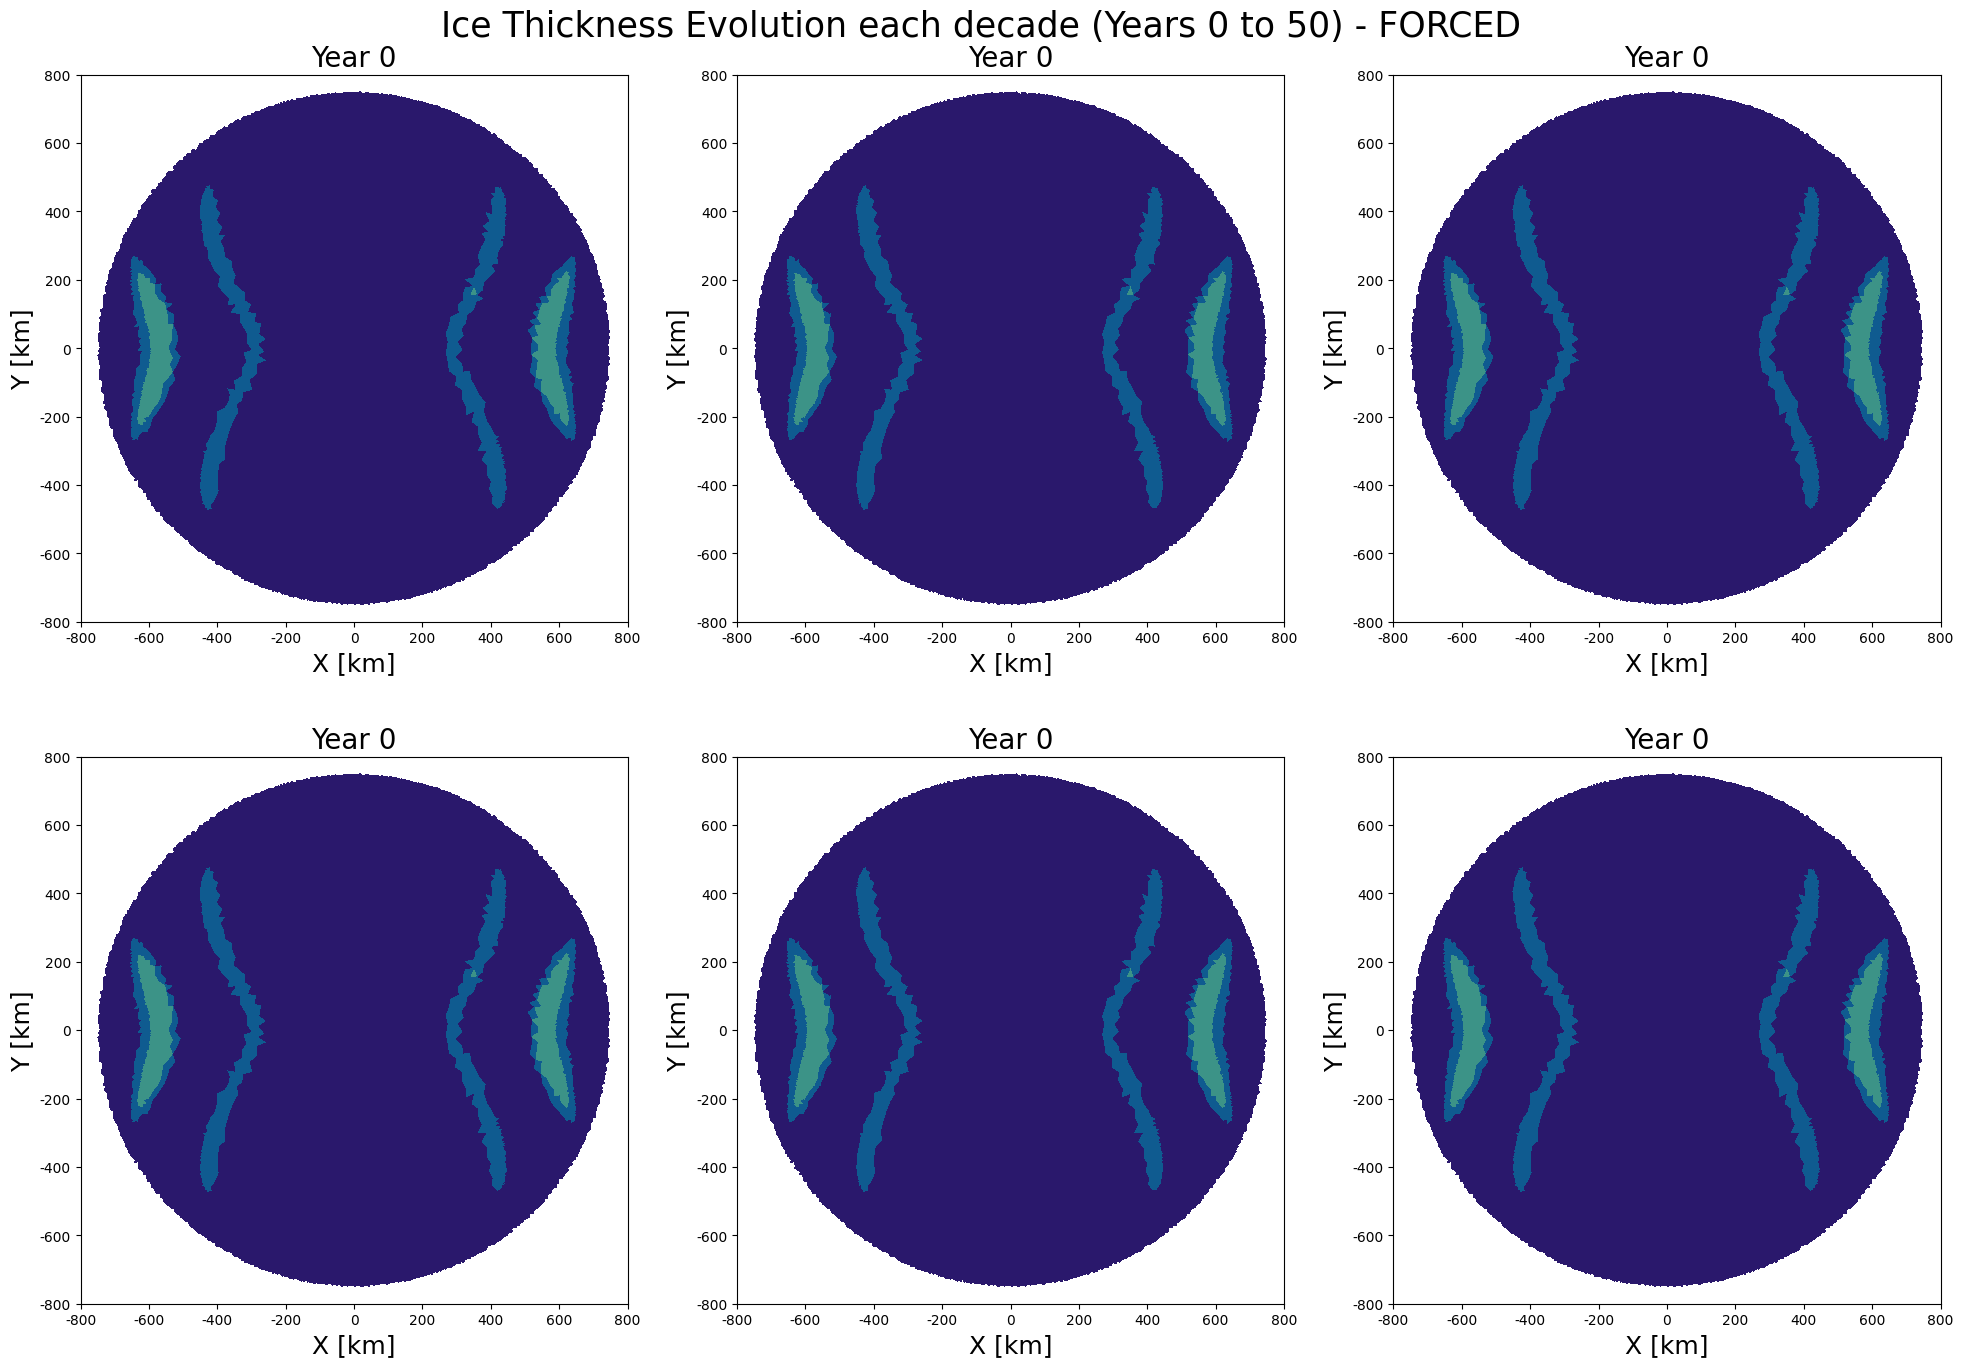

In [17]:
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.1, 1], hspace=0.1)

axes = []
for i in range(6):
    if i < 3:
        axes.append(plt.subplot(gs[0, i]))  # First row
    else:
        axes.append(plt.subplot(gs[2, i-3]))  # Third row

for i, year in enumerate(years):
    ax = axes[i]
    #GL = Lad1['grounding_line'][year]
    c0 = ax.tripcolor(triang, Hi[year].where(mask_ocean ),norm = norm, cmap=cmap)

    #ax.plot(GL[0, :], GL[1, :], color='black', linewidth=3, label='Grounding Line')
    
    ax.set_title(f'Year {year}', fontsize=tfs)
    ax.set_xlabel('X [km]', fontsize=afs)
    ax.set_ylabel('Y [km]', fontsize=afs)
    ax.set_xticks(np.arange(-n, n + 1, 200000))
    ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_yticks(np.arange(-n, n + 1, 200000))
    ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_xlim(-n, n)
    ax.set_ylim(-n, n)
    ax.set_aspect('equal')


ax.legend(loc='upper left', bbox_to_anchor=(-0.01, 1.146), edgecolor='white', fontsize=16, frameon=False)
# Add legend in the middle row
legend_ax = plt.subplot(gs[1, :])  # Span all columns in middle row
legend_ax.axis('off')  # Hide axes

plt.suptitle('Ice Thickness Evolution each decade (Years 0 to 50) - FORCED', fontsize=tfs+5, y=0.92)  

plt.tight_layout()
plt.show()

In [ ]:
# Your custom color bins
solid_colors = {
    '>400': '#3A0CA3',   # Deep blue
    '300-400': '#4361EE', # Bright blue
    '200-300': '#4CC9F0', # Light teal-blue
    '100-200': '#F72585', # Vibrant pink
    '0-100': '#FFCBF2'    # Light pink
}

# Load your data for both years
data_year50 = Hi_l[50].where(mask50 & mask_ocean).values.flatten()
data_year50 = data_year50[~np.isnan(data_year50)]  # Remove NaN values

data_year0 = Hi_l[10].where(mask10 & mask_ocean).values.flatten()
data_year0 = data_year0[~np.isnan(data_year0)]  # Remove NaN values

# Calculate data range
data_min, data_max = 0, 700
print(f"Data range: {data_min:.1f} to {data_max:.1f} m")  # Verify range matches expectations

# Create figure
plt.figure(figsize=(12, 7))

# Set number of bins
num_bins = 150

# First plot the year 0 distribution in background (faded)
n0, bins0, patches0 = plt.hist(data_year0, bins=num_bins, 
                              edgecolor='none', 
                              alpha=0.3,  # More transparent
                              color='gray',  # Unified faded color
                              label='Year 0 Distribution')

# Then plot the year 50 distribution
n50, bins50, patches50 = plt.hist(data_year50, bins=num_bins, 
                                edgecolor='none', 
                                alpha=0.8)

# Color each bar according to your thresholds (only for year 50)
for patch, bin_left, bin_right in zip(patches50, bins50[:-1], bins50[1:]):
    bin_center = (bin_left + bin_right)/2
    
    if bin_center > 400:
        patch.set_facecolor(solid_colors['>400'])
    elif bin_center > 300:
        patch.set_facecolor(solid_colors['300-400'])
    elif bin_center > 200:
        patch.set_facecolor(solid_colors['200-300'])
    elif bin_center > 100:
        patch.set_facecolor(solid_colors['100-200'])
    else:
        patch.set_facecolor(solid_colors['0-100'])

# Add statistical markers (for year 50)
average = Hi_mean
avg_line = plt.axvline(x=average, color='black', linestyle='-', linewidth=2)

# Create combined legend
from matplotlib.lines import Line2D

# Color range patches
color_patches = [mpatches.Patch(color=color, label=label) 
                for label, color in solid_colors.items()]

# Statistical line markers
stat_lines = [
    Line2D([0], [0], color='black', linestyle='-', lw=2, label=f'Average: {average:.1f} m'),
    mpatches.Patch(color='gray', alpha=0.3, label='Year 10 ')
]

# Combine all legends
first_legend = plt.legend(handles=color_patches, 
                         bbox_to_anchor=(0.78, 1), 
                         loc='upper left',
                         title='Thickness Ranges', 
                         fontsize=14, 
                         title_fontsize=16)

# Add the second legend manually
plt.gca().add_artist(first_legend)
plt.legend(handles=stat_lines, 
          bbox_to_anchor=(0.753, 0.68), 
          loc='upper left', 
          fontsize=14)

# Format plot
plt.title('Floating Ice Thickness Distribution (year 50) - FORCED', 
          fontsize=tfs, pad=20)
plt.xlabel('Ice Thickness [m]', fontsize =afs)
plt.xticks(fontsize=tifs)
plt.yticks(fontsize=tifs)
plt.ylabel('Frequency', fontsize=afs)
plt.grid(axis='y', alpha=0.3)
plt.xlim(max(0, data_min*0.9), min(500, data_max*1.1))

plt.tight_layout()
plt.show()

NameError: name 'Hi_l' is not defined

In [ ]:
plt.close('all')

## Basal melting 

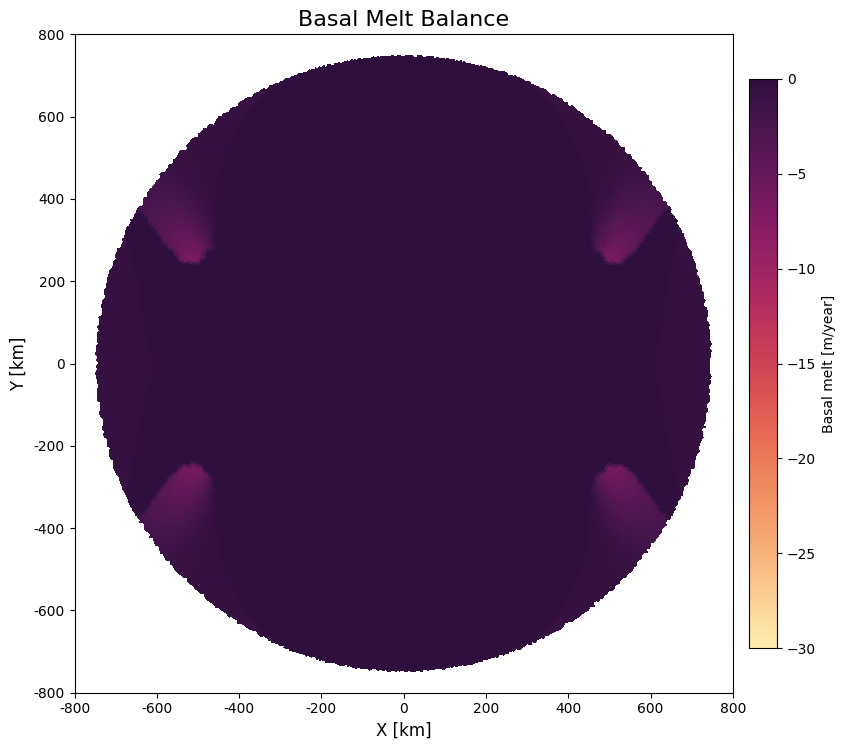

In [30]:
colorbar_kwargs = {
    'aspect': 20,
    'pad': 0.01,
    'shrink': 0.865, 
}

# Create the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(16, 8)) 

# Plot the basal melt balance
c0 = ax.tripcolor(triang, BMB[u].where(mask_ocean), cmap=cmo.matter, vmin=-30, vmax=0)
fig.colorbar(c0, ax=ax, label="Basal melt [m/year]", **colorbar_kwargs)
ax.set_title('Basal Melt Balance', fontsize=16)

# Set axis properties
ax.set_aspect('equal')
ax.set_xlabel('X [km]', fontsize=12)
ax.set_ylabel('Y [km]', fontsize=12)
ax.set_xticks(np.arange(-n, n + 1, 200000))
ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
ax.set_yticks(np.arange(-n, n + 1, 200000))
ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
ax.set_xlim(-n, n)
ax.set_ylim(-n, n)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

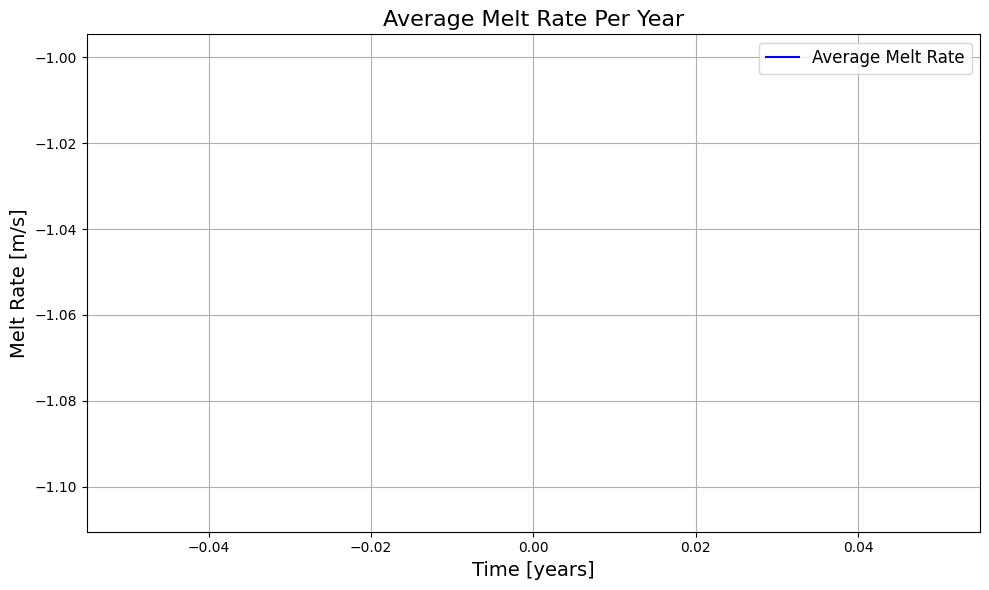

In [34]:
# Calculate the average melt rate per year
average_melt_rate = BMB.where(mask0 & mask_ocean & (Hib<-300)).mean(dim='vi')

# Plot the average melt rate
plt.figure(figsize=(10, 6))
plt.plot(BMB['time'], average_melt_rate, label='Average Melt Rate', color='blue')
plt.xlabel('Time [years]', fontsize=14)
plt.ylabel('Melt Rate [m/s]', fontsize=14)
plt.title('Average Melt Rate Per Year', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [36]:
BMB =  BMB[0].where(mask_ocean & mask0 & (Hib[0] <(-300)))
BMB.mean().values

array(-1.05255909)

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_15176/509739401.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.5)  # Reduced padding


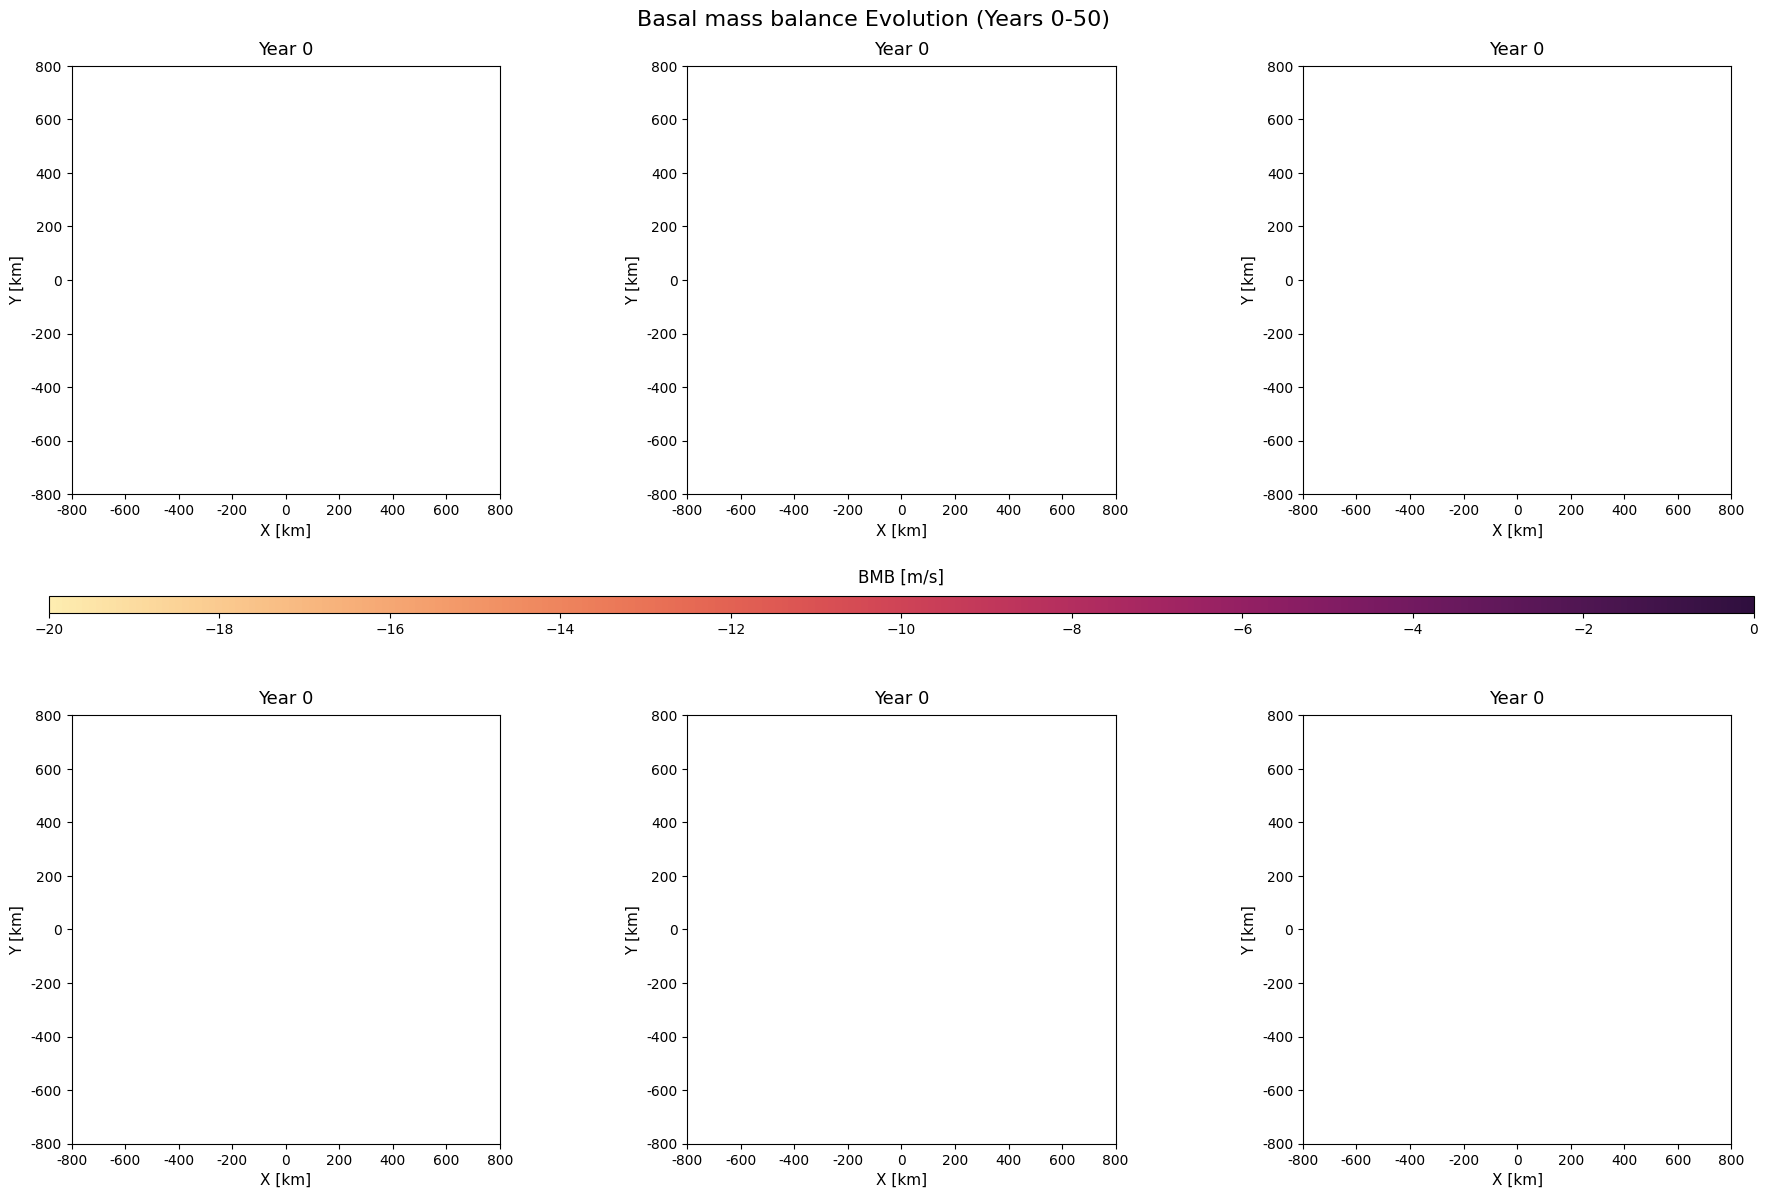

In [37]:
fig = plt.figure(figsize=(22, 14))  # Slightly reduced figure size
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.04, 1], hspace=0.35, wspace=0.3)  # Tighter spacing

# Create subplots
axes = []
for i in range(6):
    if i < 3:
        axes.append(fig.add_subplot(gs[0, i]))  # First row
    else:
        axes.append(fig.add_subplot(gs[2, i-3]))  # Third row

# Create horizontal colorbar axis between rows
cax = fig.add_subplot(gs[1, :])  # Span all columns in middle row

for i, year in enumerate(years):
    ax = axes[i]
     # Mask for grounded ice
    # Main plot with contour lines
    c0 = ax.tripcolor(triang, BMB[year].where(mask0 & mask_ocean), cmap=cmo.matter, vmin=-20, vmax=0)
    #contours = ax.tricontour(triang, Hi_l[year].where(mask_rock), 
    #                        levels=np.arange(0, 301, 50), 
    #                        colors='k', linewidths=0.7)  # Darker contours
    #ax.clabel(contours, inline=True, fontsize=9, fmt='%d m')
    
    # Axis formatting
    ax.set_title(f'Year {year}', fontsize=13, pad=8)  # Reduced padding
    ax.set_xlabel('X [km]', fontsize=11)
    ax.set_ylabel('Y [km]', fontsize=11)
    ax.set_xticks(np.arange(-n, n+1, 200000))
    ax.set_yticks(np.arange(-n, n+1, 200000))
    ax.set_xticklabels(np.arange(-800, 801, 200))  # Direct labels
    ax.set_yticklabels(np.arange(-800, 801, 200))
    ax.set_xlim(-n, n)
    ax.set_ylim(-n, n)
    ax.set_aspect('equal')

# Colorbar formatting
cbar = fig.colorbar(c0, cax=cax, orientation='horizontal')
cbar.set_label('BMB [m/s]', fontsize=12, labelpad=10)
cbar.set_ticks(np.linspace(-20, 0, 11))  # Add evenly spaced ticks
cax.xaxis.set_ticks_position('bottom')
cax.xaxis.set_label_position('top')

# Main title with adjusted position
plt.suptitle('Basal mass balance Evolution (Years 0-50)', 
            fontsize=16, y=0.92)  # More compact title
plt.tight_layout(pad=1.5)  # Reduced padding
plt.show()

In [ ]:
plt.close('all')

## Velocity


In [25]:
u_s = Lad['u_surf']
v_s = Lad['v_surf']
          
magice = np.sqrt(u_s**2 +v_s**2)
colorbar_kwargs = {
    'aspect': 20,
    'pad': 0.01,
    'shrink': 1, 
}

m = 20
Tricc = Lad['Tricc']

fig = plt.figure(figsize=(22, 14))  # Slightly reduced figure size
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.04, 1], hspace=0.35, wspace=0.3)  # Tighter spacing

# Create subplots
axes = []
for i in range(6):
    if i < 3:
        axes.append(fig.add_subplot(gs[0, i]))  # First row
    else:
        axes.append(fig.add_subplot(gs[2, i-3]))  # Third row

# Create horizontal colorbar axis between rows
cax = fig.add_subplot(gs[1, :])  # Span all columns in middle row

for i, year in enumerate(years):
    ax = axes[i]

    # Main plot with contour lines
    c0 = ax.tripcolor(
        Tricc[0, :], 
        Tricc[1, :], 
        magice[year], 
        cmap='viridis', 
        vmin=0, 
        vmax=400

    )
    # Axis formatting
    ax.set_title(f'Year {year}', fontsize=13, pad=8)  # Reduced padding
    ax.set_xlabel('X [km]', fontsize=11)
    ax.set_ylabel('Y [km]', fontsize=11)
    ax.set_xticks(np.arange(-n, n+1, 200000))
    ax.set_yticks(np.arange(-n, n+1, 200000))
    ax.set_xticklabels(np.arange(-800, 801, 200))  # Direct labels
    ax.set_yticklabels(np.arange(-800, 801, 200))
    ax.set_xlim(-n, n)
    ax.set_ylim(-n, n)
    ax.set_aspect('equal')


    u_s_norm = u_s[u][::m] / np.sqrt(u_s[u][::m]**2 + v_s[u][::m]**2)
    v_s_norm = v_s[u][::m] / np.sqrt(u_s[u][::m]**2 + v_s[u][::m]**2)


    ax.quiver(Tricc[0, :][::m],
        Tricc[1, :][::m],
        u_s_norm,
        v_s_norm,
        scale=40,
        width=0.002,
        headwidth=3,
        headlength=4,
        headaxislength=3
    )


# Colorbar formatting
cbar = fig.colorbar(c0, cax=cax, orientation='horizontal')
cbar.set_label('Velocity [m/s]', fontsize=12, labelpad=10)
cbar.set_ticks(np.linspace(0, 400, 11))  # Add evenly spaced ticks
cax.xaxis.set_ticks_position('bottom')
cax.xaxis.set_label_position('top')

# Main title with adjusted position
plt.suptitle('LADDIE velocity Evolution (Years 0-50) with normalized arrows', 
            fontsize=16, y=0.92)  # More compact title
plt.tight_layout(pad=1.5)  # Reduced padding
plt.show()


NameError: name 'Lad' is not defined

In [26]:
Tricc = Lad['Tricc']
u_s = Lad['u_surf']
v_s = Lad['v_surf']
          
magice = np.sqrt(u_s**2 +v_s**2)
colorbar_kwargs = {
    'aspect': 20,
    'pad': 0.01,
    'shrink': 1, 
}
u = 50
m = 10



##############################################################################################################################
fig, ax = plt.subplots(1, 1, figsize=(16, 8)) 

c0 = ax.tripcolor(
    Tricc[0, :], 
    Tricc[1, :], 
    magice[u], 
    cmap='viridis', 
    vmin=0, 
    vmax=400

)

fig.colorbar(c0, ax=ax, label="Velocity magnitude [m/y]", **colorbar_kwargs)
ax.set_title('Ice velocity', fontsize=14)


u_s_norm = u_s[u][::m] / np.sqrt(u_s[u][::m]**2 + v_s[u][::m]**2)
v_s_norm = v_s[u][::m] / np.sqrt(u_s[u][::m]**2 + v_s[u][::m]**2)


plt.quiver(Tricc[0, :][::m],
    Tricc[1, :][::m],
    u_s_norm,
    v_s_norm,
    scale=50,
    width=0.002,
    headwidth=3,
    headlength=4,
    headaxislength=3
)

plt.quiverkey(
    plt.quiver(0, 0, 0, 0, scale=10000, width=0.002),
    X=0.75,
    Y=0.97,
    U= 200,
    label=' Normalized quivers',
    labelpos='E',
    coordinates='figure',
    color='k'
)

ax.set_aspect('equal')
ax.set_xlabel('X [km]', fontsize=12)
ax.set_ylabel('Y [km]', fontsize=12)
ax.set_xticks(np.arange(-n, n + 1, 200000))
ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
ax.set_yticks(np.arange(-n, n + 1, 200000))
ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
ax.set_xlim(-n, n)
ax.set_ylim(-n, n)

plt.tight_layout()
plt.show()

NameError: name 'Lad' is not defined

In [27]:
plt.close('all')